In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.filterwarnings('ignore')

In [226]:

import os


# 1. Load FAO Food Price Index (FPI)

fao_path = "./Food_price_indices_data_may629 (2).xls"  # Replace with your path
fao_df = pd.read_excel(fao_path, sheet_name=0, skiprows=2)

# Keep only columns that are not 'Unnamed'
fao_columns = [c for c in fao_df.columns if 'Unnamed' not in c]
fao_df = fao_df[fao_columns]

# Melt to long format
fao_long = fao_df.melt(
    id_vars=['Date'],
    var_name='Commodity',
    value_name='FPI'
)

# Add Year and Month
fao_long['Year'] = fao_long['Date'].dt.year
fao_long['Month'] = fao_long['Date'].dt.month

print("FAO FPI long shape:", fao_long.shape)
fao_long.head()

# 2. Load FAO monthly Food CPI (.dta)

fcpi_path = "./Inflation-data/fcpi_m.dta"  # Replace with your path
fcpi_df = pd.read_stata(fcpi_path)

# Keep only Country + numeric monthly columns (ignore _Note)
fcpi_df = fcpi_df[['Country'] + [c for c in fcpi_df.columns if c.startswith('_') and c[1:].isdigit()]]

# Melt wide to long
fcpi_long = fcpi_df.melt(
    id_vars=['Country'],
    var_name='YearMonth',
    value_name='Food_CPI'
)

# Convert YearMonth to datetime
fcpi_long['YearMonth'] = fcpi_long['YearMonth'].str.replace('_','')
fcpi_long['Date'] = pd.to_datetime(fcpi_long['YearMonth'], format='%Y%m')
fcpi_long['Year'] = fcpi_long['Date'].dt.year
fcpi_long['Month'] = fcpi_long['Date'].dt.month
fcpi_long.drop(columns=['YearMonth'], inplace=True)

print("FAO Food CPI long shape:", fcpi_long.shape)
fcpi_long.head()


# 3. Load World Bank CPI

cpi_path = "./API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195 (1)/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv"
cpi_df = pd.read_csv(cpi_path, skiprows=4)

# Melt wide to long
cpi_long = cpi_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='CPI'
)

# Keep only numeric years
cpi_long = cpi_long[cpi_long['Year'].str.isnumeric()]
cpi_long['Year'] = cpi_long['Year'].astype(int)
cpi_long.dropna(subset=['CPI'], inplace=True)

print("World Bank CPI long shape:", cpi_long.shape)
cpi_long.head()


# 4. Load World Bank GDP Deflator

gdp_path = "./API_NY.GDP.DEFL.KD.ZG_DS2_en_csv_v2_22672 (1)/API_NY.GDP.DEFL.KD.ZG_DS2_en_csv_v2_22672.csv"
gdp_df = pd.read_csv(gdp_path, skiprows=4)

# Melt wide to long
gdp_long = gdp_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='GDP_Deflator'
)

# Keep only numeric years
gdp_long = gdp_long[gdp_long['Year'].str.isnumeric()]
gdp_long['Year'] = gdp_long['Year'].astype(int)
gdp_long.dropna(subset=['GDP_Deflator'], inplace=True)

print("World Bank GDP Deflator long shape:", gdp_long.shape)
gdp_long.head()


# 5. Merge datasets

# Merge FAO FPI with FAO CPI on Year and Month
merged = pd.merge(
    fao_long,
    fcpi_long[['Country','Year','Month','Food_CPI']],
    on=['Year','Month'],
    how='left'
)

# Merge with World Bank CPI on Year
merged = pd.merge(
    merged,
    cpi_long[['Country Name','Year','CPI']],
    left_on=['Country','Year'],
    right_on=['Country Name','Year'],
    how='left'
)

# Merge with GDP Deflator on Year
merged = pd.merge(
    merged,
    gdp_long[['Country Name','Year','GDP_Deflator']],
    left_on=['Country','Year'],
    right_on=['Country Name','Year'],
    how='left'
)

# Drop redundant columns
merged.drop(columns=['Country Name_x','Country Name_y'], inplace=True, errors='ignore')

print("Merged dataset shape:", merged.shape)
merged.head()


FAO FPI long shape: (2334, 5)
FAO Food CPI long shape: (113373, 5)
World Bank CPI long shape: (6284, 6)
World Bank GDP Deflator long shape: (14019, 6)
Merged dataset shape: (398094, 9)


,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
0,NaT,Food Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872,2.999681
2,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Belgium,NaN,3.448312,2.812404
3,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Canada,57.93543,4.780477,3.352302
4,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Chile,NaN,26.036481,22.553700


FAO FPI (Food Price Index)

.Tracks global food prices for different commodities (like sugar, wheat, rice).

.Helps see how the price of each food item changes worldwide over time.

FAO Food_CPI (Food Consumer Price Index)

.Tracks food prices that people actually pay in each country.

.Shows how food inflation differs from country to country.

World Bank CPI (Consumer Price Index)

.Tracks overall price changes for all goods and services in a country.

.Lets you compare food price changes vs general inflation.

World Bank GDP Deflator

.Measures inflation for all goods and services produced in a country.


In [227]:
#  Save merged CSV for later use 
merged.to_csv("merged_clean.csv", index=False)
print("Merged CSV saved as 'merged_clean.csv'")

Merged CSV saved as 'merged_clean.csv'


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398094 entries, 0 to 398093
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          398088 non-null  datetime64[ns]
 1   Commodity     398094 non-null  object        
 2   FPI           398088 non-null  float64       
 3   Year          398088 non-null  float64       
 4   Month         398088 non-null  float64       
 5   Country       398088 non-null  object        
 6   Food_CPI      209028 non-null  float64       
 7   CPI           207480 non-null  float64       
 8   GDP_Deflator  326976 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 27.3+ MB


FAO FPI – Global commodity-level food prices (monthly)
 Shows how global food prices change, per commodity.

FAO Food_CPI – Country-level food price index (monthly)
 Shows how food prices paid by consumers in each country change over time.

World Bank CPI – Country-level overall consumer price index (annual)
 Lets you compare food-specific inflation vs general inflation.

World Bank GDP Deflator – Country-level inflation of all goods/services (annual)
 Can be used as another measure of inflation and economic context.

In [ ]:
merged.isnull().sum()

Date                 6
Commodity            0
FPI                  6
Year                 6
Month                6
Country              6
Food_CPI        189066
CPI             190614
GDP_Deflator     71118
dtype: int64

In [ ]:
merged.head()

,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
0,NaT,Food Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872,2.999681
2,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Belgium,NaN,3.448312,2.812404
3,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Canada,57.93543,4.780477,3.352302
4,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Chile,NaN,26.036481,22.553700


In [ ]:
merged.tail()

,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
398089,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398090,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398091,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398092,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398093,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN


In [ ]:

# Count of unique countries
num_countries = merged['Country'].nunique()
print("Number of unique countries:", num_countries)

Number of unique countries: 152


In [ ]:
print("Unique commodities:", merged["Commodity"].unique())

Unique commodities: ['Food Price Index' 'Meat' 'Dairy' 'Cereals' 'Oils' 'Sugar']


In [ ]:
# List all unique countries
unique_countries = merged['Country'].unique()
print("Countries in dataset:", unique_countries)


Countries in dataset: [nan 'Austria' 'Belgium' 'Canada' 'Chile' 'China' 'Colombia'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Korea, Rep.' 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'Saudi Arabia' 'Slovakia' 'Slovenia'
 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Turkey' 'United Kingdom'
 'United States' 'Angola' 'Brazil' 'Costa Rica' 'Ghana' 'India'
 'Indonesia' 'Jamaica' 'Kenya' 'Maldives' 'Malta' 'Myanmar' 'Panama'
 'Philippines' 'Puerto Rico' 'Romania' 'Russian Federation' 'Singapore'
 'Sri Lanka' 'Suriname' 'Taiwan, China' 'Tanzania, United Rep.' 'Thailand'
 'Uganda' 'United Arab Emirates' 'Uruguay' 'Venezuela, RB' 'Afghanistan'
 'Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana'
 'Brunei Darussalam' 'Bu

In [ ]:
# Filter dataset for Kenya
kenya_data = merged[merged['Country'] == 'Kenya']

# Show first few rows
display(kenya_data.head())

# Number of rows for Kenya
print("Number of rows for Kenya:", len(kenya_data))


,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
46,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Kenya,NaN,NaN,10.637199
217,1990-02-01,Food Price Index,64.453560,1990.0,2.0,Kenya,NaN,NaN,10.637199
388,1990-03-01,Food Price Index,63.787064,1990.0,3.0,Kenya,NaN,NaN,10.637199
559,1990-04-01,Food Price Index,65.766754,1990.0,4.0,Kenya,NaN,NaN,10.637199
730,1990-05-01,Food Price Index,64.378874,1990.0,5.0,Kenya,NaN,NaN,10.637199


Number of rows for Kenya: 2328


In [ ]:
merged.describe()

,Date,FPI,Year,Month,Food_CPI,CPI,GDP_Deflator
count,398088,398088.000000,398088.000000,398088.000000,2.090280e+05,207480.000000,326976.000000
mean,2006-02-14 20:32:09.896907008,84.202088,2005.670103,6.458763,2.597849e+03,10.729133,30.627325
min,1990-01-01 00:00:00,31.809300,1990.000000,1.000000,0.000000e+00,-16.859691,-31.565915
25%,1998-01-24 06:00:00,61.239687,1998.000000,3.000000,6.541211e+01,1.509495,1.738110
50%,2006-02-15 00:00:00,79.072945,2006.000000,6.000000,8.783990e+01,3.210810,4.334583
75%,2014-03-08 18:00:00,101.072169,2014.000000,9.000000,1.020027e+02,6.601326,10.078789
max,2022-04-01 00:00:00,251.831272,2022.000000,12.000000,8.053641e+06,2947.732772,15444.420423
std,NaN,29.472696,9.335369,3.459766,1.197301e+05,88.763239,328.873073


# EDA

In [ ]:
# 1. Numerical features

numerical_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']

In [ ]:
eda_df = merged[numerical_cols].copy()

In [ ]:
# Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12,6)

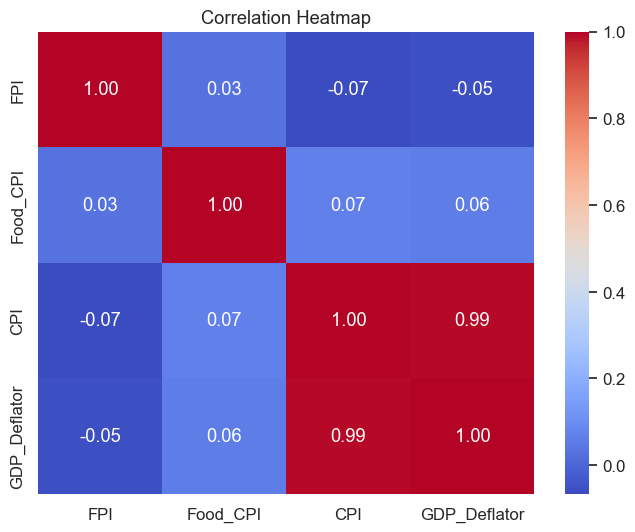

In [ ]:
# 2. Heatmap of correlations

plt.figure(figsize=(8,6))
corr = eda_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Extreme Multicollinearity: The correlation of r=0.99 between the CPI and the GDP_Deflator indicates near-perfect multicollinearity.

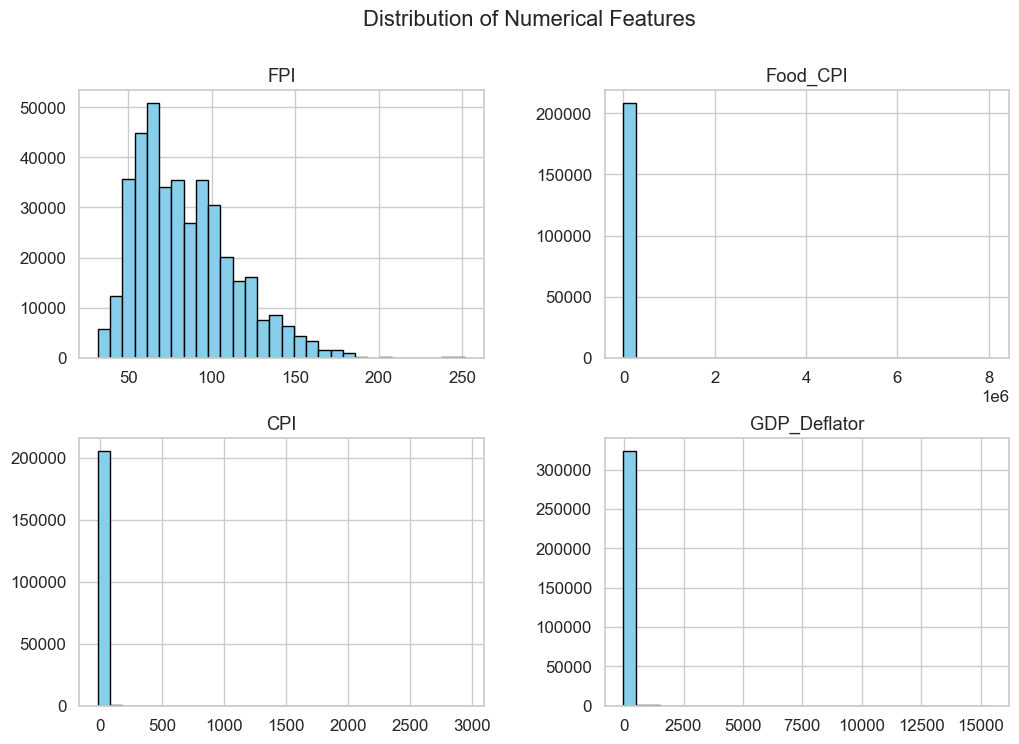

In [ ]:
# 3. Histograms 

eda_df.hist(bins=30, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

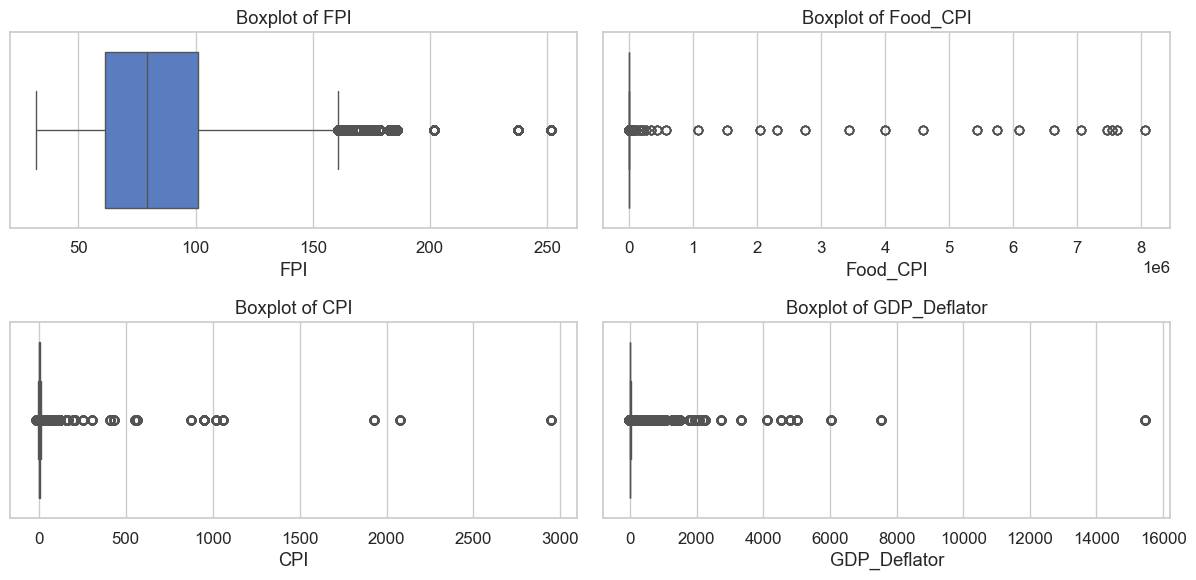

In [ ]:

num_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x=merged[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

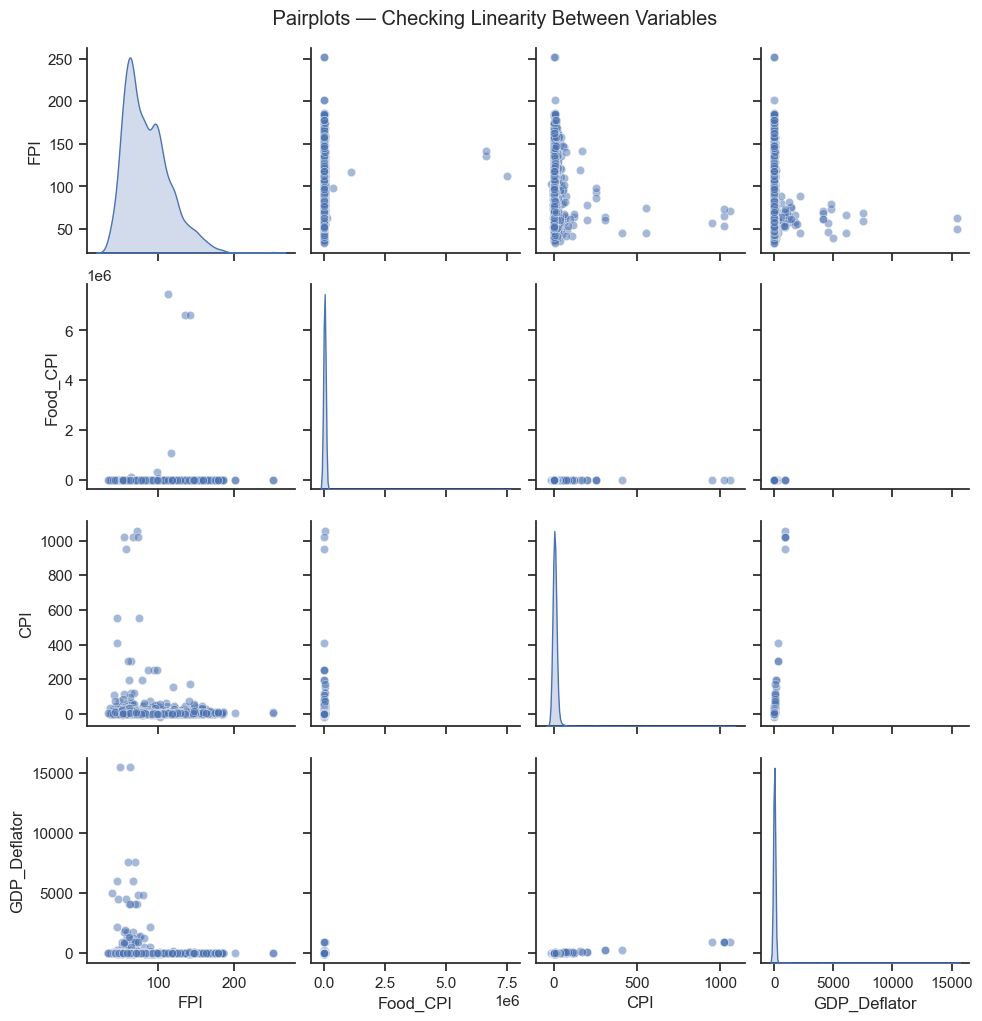

In [ ]:
# Pairplot (scatterplots + histograms)
sample_df = eda_df.sample(n=5000, random_state=42)
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(10,8))
pair_plot = sns.pairplot(sample_df, diag_kind="kde", plot_kws={"alpha": 0.5})

pair_plot.fig.suptitle(" Pairplots — Checking Linearity Between Variables", y=1.02)
plt.show()

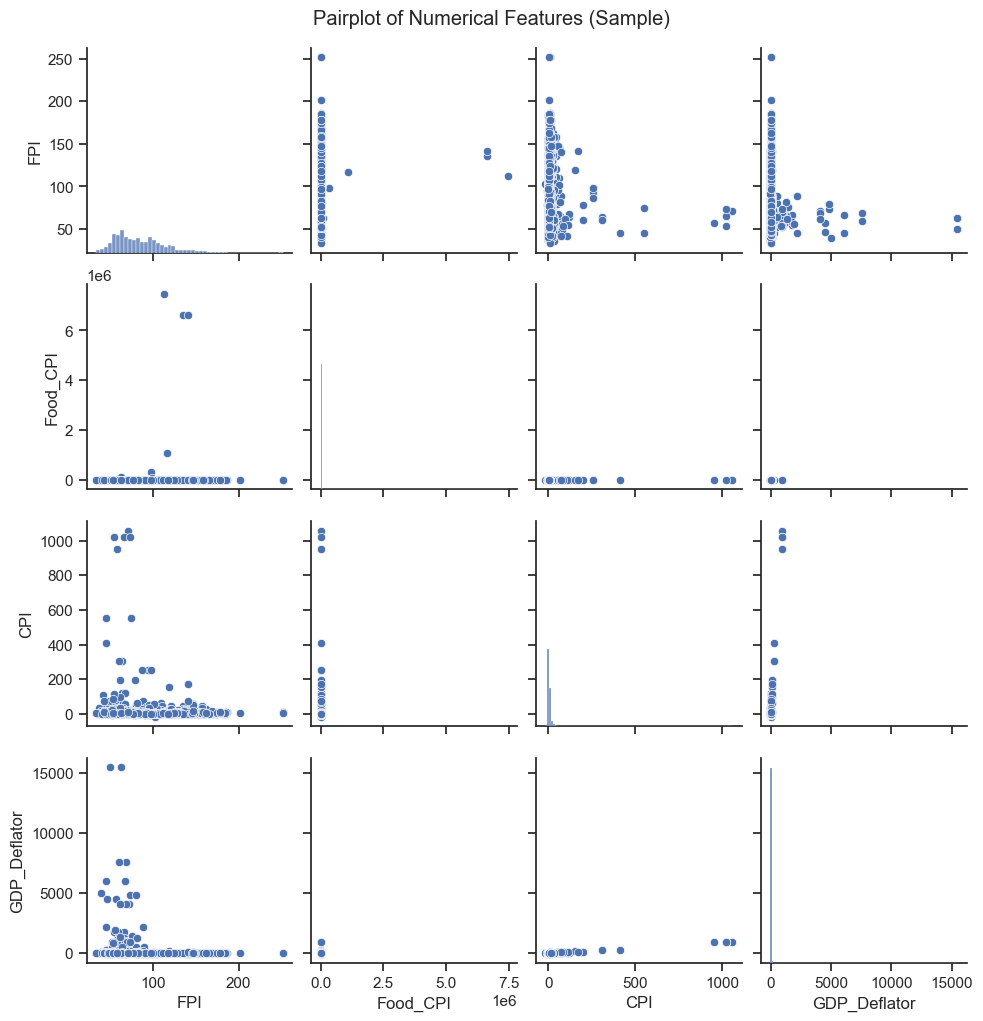

In [ ]:
# 5. Pairplot (sample for performance)

sample_df = eda_df.sample(n=5000, random_state=42)  # sample to speed up plotting
sns.pairplot(sample_df)
plt.suptitle("Pairplot of Numerical Features (Sample)", y=1.02)
plt.show()

CPI vs. GDP_Deflator (Inferred from r=0.99)	Points lie tightly along a straight, upward line.	Highly Linear

FPI vs. CPI	Scattered vertically, no discernible straight line pattern.	Non-Linear

FPI vs. GDP_Deflator	Scattered vertically, no discernible straight line pattern.	Non-Linear

Food_CPI vs. All Others	Dominated by clustering near zero and extreme outliers.	Non-Linear

In [ ]:


# Aggregate per year & commodity
agg = merged.groupby(['Year','Commodity']).agg({
    'FPI':'mean',
    'Food_CPI':'mean',
    'CPI':'mean'
}).reset_index()


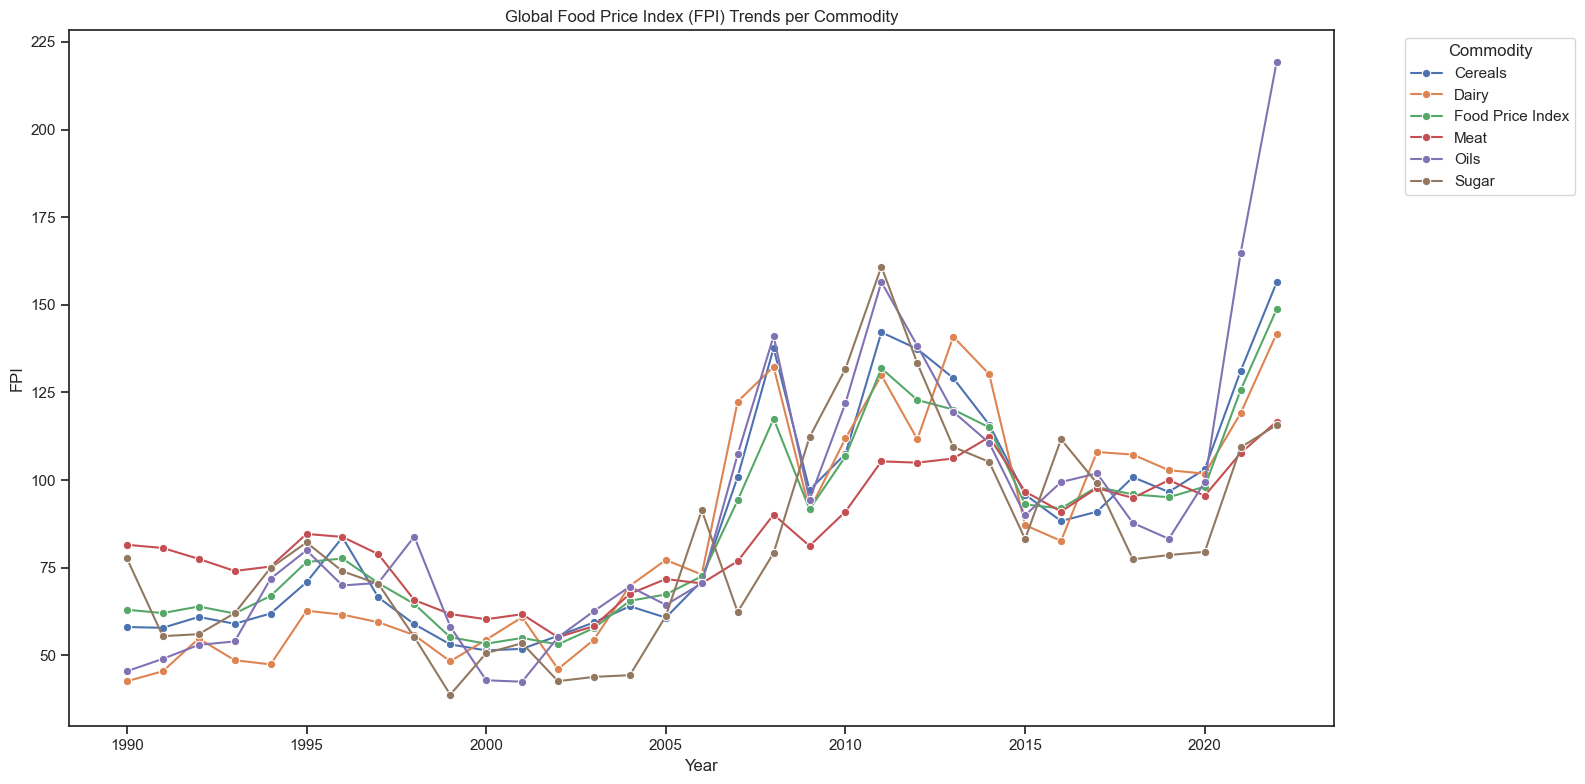

In [ ]:
# Plot FPI trends per commodity
plt.figure(figsize=(16,8))
sns.lineplot(data=agg, x='Year', y='FPI', hue='Commodity', marker='o')
plt.title('Global Food Price Index (FPI) Trends per Commodity')
plt.ylabel('FPI')
plt.xlabel('Year')
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values

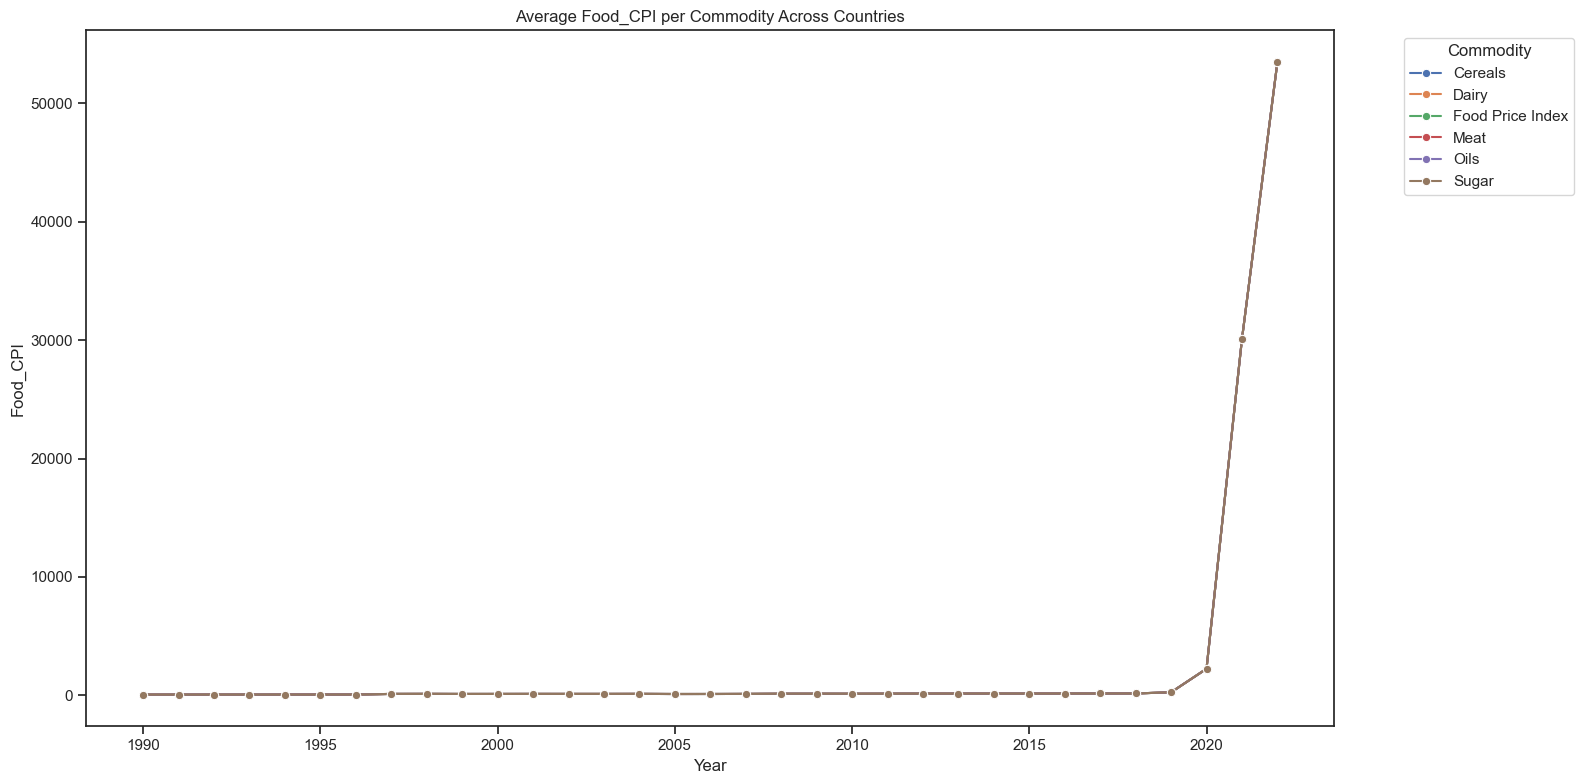

In [ ]:
#  plot Food_CPI and CPI per commodity (only for countries with Food_CPI)
plt.figure(figsize=(16,8))
sns.lineplot(data=agg, x='Year', y='Food_CPI', hue='Commodity', marker='o')
plt.title('Average Food_CPI per Commodity Across Countries')
plt.ylabel('Food_CPI')
plt.xlabel('Year')
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


sudden acceleration of the average food consumer price index across countries, concentrated entirely in the period after 2020.

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values.

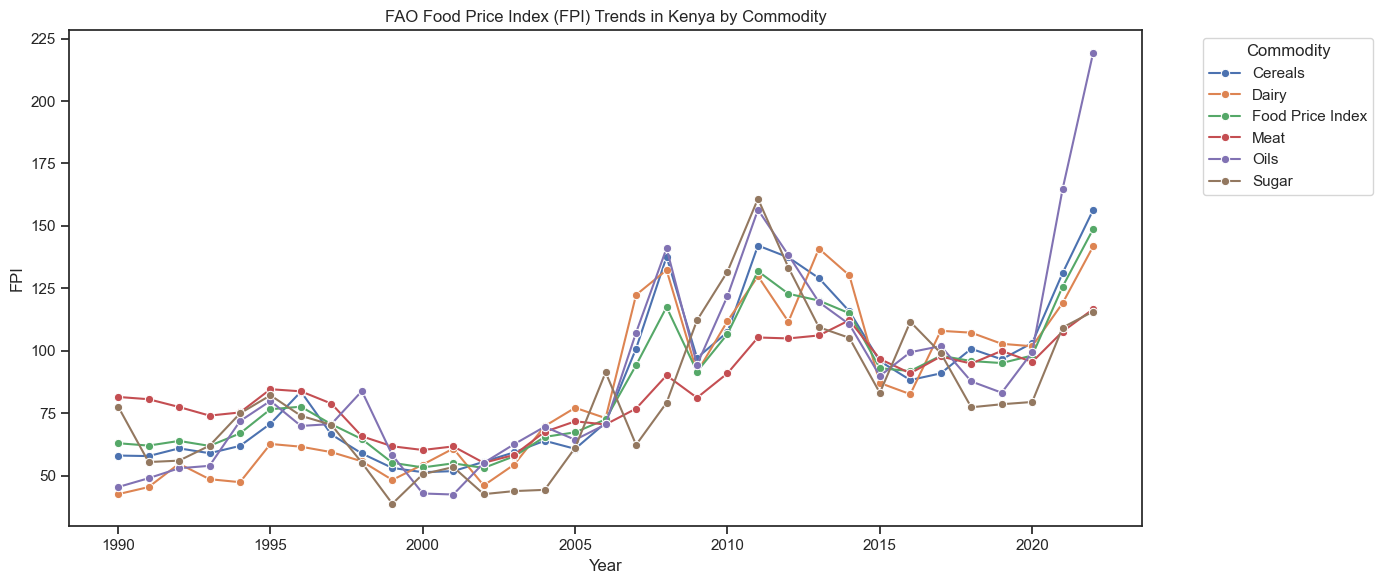

In [ ]:
# Filter for Kenya
kenya_data = merged[merged['Country'] == 'Kenya']

# Aggregate by Year and Commodity for FPI
fpi_trends = kenya_data.groupby(['Year','Commodity'])['FPI'].mean().reset_index()

# Plot FPI trends
plt.figure(figsize=(14,6))
sns.lineplot(data=fpi_trends, x='Year', y='FPI', hue='Commodity', marker='o')
plt.title("FAO Food Price Index (FPI) Trends in Kenya by Commodity")
plt.xlabel("Year")
plt.ylabel("FPI")
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Aggregate globally per year
global_fpi = merged.groupby('Year')['FPI'].mean().dropna()

# ADF Test
adf_result = adfuller(global_fpi)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("Result: Data is likely stationary ")
else:
    print("Result: Data is likely non-stationary ")


ADF Statistic: 0.8921954118819269
p-value: 0.9929876243917356
Critical Values: {'1%': np.float64(-3.7529275211638033), '5%': np.float64(-2.998499866852963), '10%': np.float64(-2.6389669754253307)}
Result: Data is likely non-stationary 


In [ ]:
# Check how many years we have
n_points = len(global_fpi)
max_lags = n_points // 2  # 50% of available points

print(f"Number of years: {n_points}, using max lags = {max_lags}")

Number of years: 33, using max lags = 16


<Figure size 1200x400 with 0 Axes>

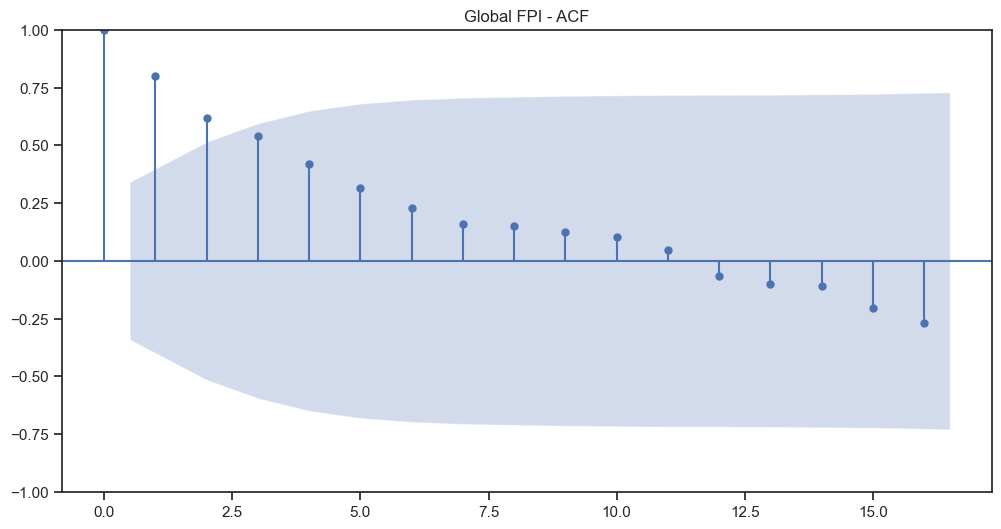

<Figure size 1200x400 with 0 Axes>

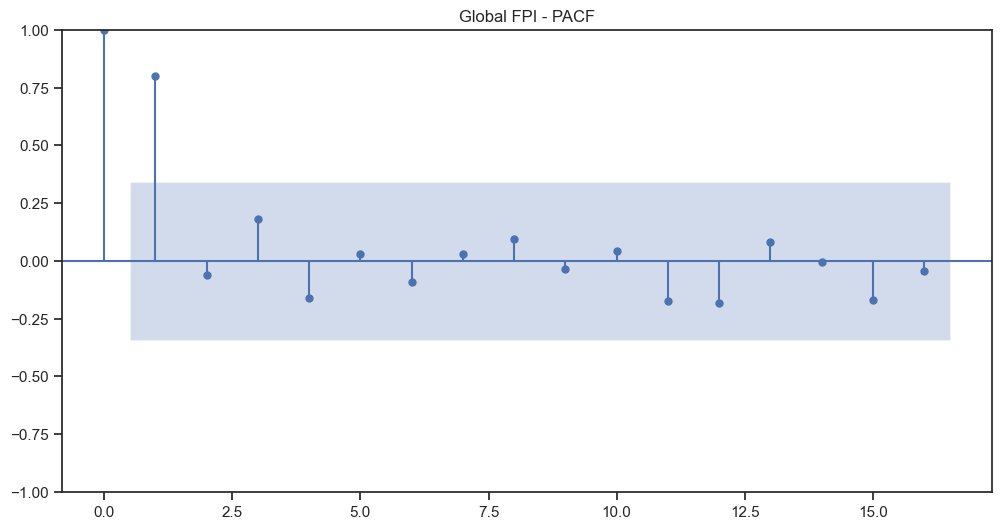

In [ ]:
# ACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plot_acf(global_fpi, lags=max_lags)
plt.title("Global FPI - ACF")
plt.show()

# PACF plot
plt.figure(figsize=(12,4))
plot_pacf(global_fpi, lags=max_lags, method='ywm')
plt.title("Global FPI - PACF")
plt.show()

The ACF plot indicates that the Global Food Price Index is highly correlated with its own past values, showing strong persistence and likely the presence of a long-term trend.
The clear and decisive cut-off after Lag 1 suggests that the time series has an underlying Autoregressive process of order1
The positive correlation slowly decays as the lag increases, remaining positive and statistically significant up to approximately lag 12. This long, slow decay of the autocorrelation is a classic indicator of a non-stationary time series

# Preprocessing

In [ ]:
# Check missing values
missing = merged.isna().sum().sort_values(ascending=False)
missing_percent = (merged.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing Values': missing,
    'Missing %': missing_percent
})
print("Missing values summary:")
print(missing_summary)


Missing values summary:
              Missing Values  Missing %
CPI                   190614      47.88
Commodity                  0       0.00
Country                    6       0.00
Date                       6       0.00
FPI                        6       0.00
Food_CPI              189066      47.49
GDP_Deflator           71118      17.86
Month                      6       0.00
Year                       6       0.00


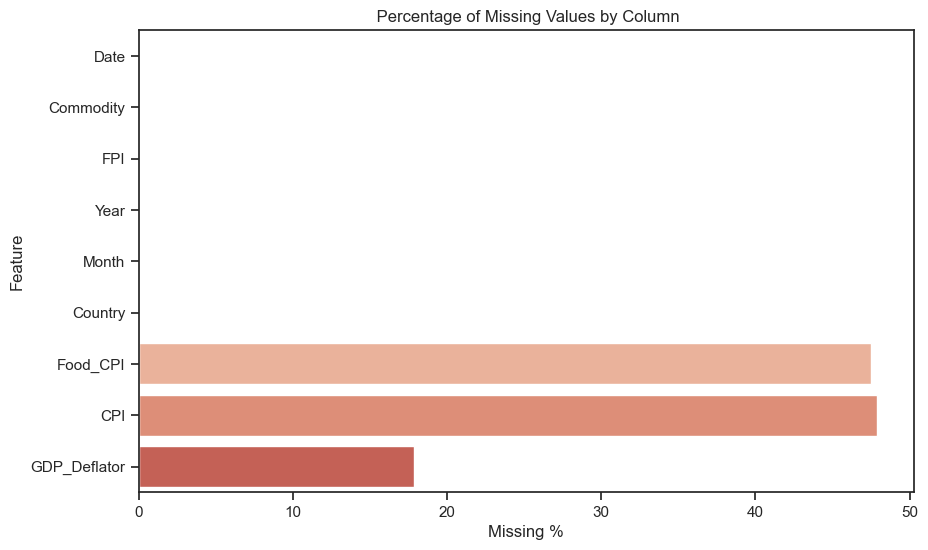

In [ ]:


#  Bar Plot of Missingness ---
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent, y=missing_percent.index, palette="coolwarm")
plt.title(" Percentage of Missing Values by Column")
plt.xlabel("Missing %")
plt.ylabel("Feature")
plt.show()

In [ ]:
# CPI and GDP_Deflator have r ~ 0.99 => drop GDP_Deflator
merged.drop(columns=['GDP_Deflator'], inplace=True)

In [ ]:
# Fill missing Country names (if some are global records)
merged['Country'] = merged['Country'].fillna('Global')


In [ ]:
merged['Food_CPI'] = merged.groupby('Country')['Food_CPI'].transform(lambda x: x.interpolate(method='linear'))
merged['CPI'] = merged.groupby('Country')['CPI'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [ ]:
# Set Date as index
merged['Date'] = pd.to_datetime(merged['Date'])
merged.set_index('Date', inplace=True)

In [ ]:
merged.sort_index(inplace=True)  #ensures dates go from oldest → newest

In [ ]:
merged.isnull().sum()

Commodity        0
FPI              6
Year             6
Month            6
Country          0
Food_CPI     81291
CPI          65190
dtype: int64

In [ ]:
merged.head()

,Commodity,FPI,Year,Month,Country,Food_CPI,CPI
Date,,,,,,,
1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872
1990-01-01,Oils,44.587672,1990.0,1.0,,NaN,NaN
1990-01-01,Oils,44.587672,1990.0,1.0,,NaN,NaN
1990-01-01,Oils,44.587672,1990.0,1.0,,NaN,NaN
1990-01-01,Oils,44.587672,1990.0,1.0,,NaN,NaN


In [ ]:
merged.isna().sum()


Commodity        0
FPI              6
Year             6
Month            6
Country          0
Food_CPI     81291
CPI          65190
dtype: int64

In [ ]:
# Fill remaining missing Food_CPI per country with median
merged['Food_CPI'] = merged.groupby('Country')['Food_CPI'].transform(
    lambda x: x.fillna(x.median())
)

# Fill remaining missing CPI per country with median
merged['CPI'] = merged.groupby('Country')['CPI'].transform(
    lambda x: x.fillna(x.median())
)


In [ ]:
merged.isna().sum()

Commodity        0
FPI              6
Year             6
Month            6
Country          0
Food_CPI     60534
CPI          65190
dtype: int64

In [ ]:
merged['Food_CPI'] = merged['Food_CPI'].fillna(merged['Food_CPI'].median())
merged['CPI'] = merged['CPI'].fillna(merged['CPI'].median())


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398094 entries, 1990-01-01 to NaT
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Commodity  398094 non-null  object 
 1   FPI        398088 non-null  float64
 2   Year       398088 non-null  float64
 3   Month      398088 non-null  float64
 4   Country    398094 non-null  object 
 5   Food_CPI   398094 non-null  float64
 6   CPI        398094 non-null  float64
dtypes: float64(5), object(2)
memory usage: 24.3+ MB


In [ ]:
#  Drop Year and Month columns 
if 'Year' in merged.columns and 'Month' in merged.columns:
    merged = merged.drop(columns=['Year', 'Month'])

In [ ]:
# Keep only rows with a valid Date index
merged = merged[merged.index.notna()]


In [ ]:
merged.isnull().sum()

Commodity    0
FPI          0
Country      0
Food_CPI     0
CPI          0
dtype: int64

In [ ]:
merged.head()

,Commodity,FPI,Country,Food_CPI,CPI
Date,,,,,
1990-01-01,Food Price Index,64.145081,Austria,59.46581,3.261872
1990-01-01,Oils,44.587672,,92.59000,4.625484
1990-01-01,Oils,44.587672,,92.59000,4.625484
1990-01-01,Oils,44.587672,,92.59000,4.625484
1990-01-01,Oils,44.587672,,92.59000,4.625484


In [ ]:
merged.tail()

,Commodity,FPI,Country,Food_CPI,CPI
Date,,,,,
2022-04-01,Cereals,169.478971,Puerto Rico,92.5900,4.625484
2022-04-01,Cereals,169.478971,Philippines,112.5000,5.821158
2022-04-01,Cereals,169.478971,Panama,105.0078,2.859651
2022-04-01,Cereals,169.478971,Malta,119.9000,6.153756
2022-04-01,Sugar,121.791250,,92.5900,4.625484


In [ ]:
#  Handle Outliers (Capping using IQR method)

numerical_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']

def cap_outliers(merged, cols):
    outlier_summary = {}

    for col in cols:
        if col not in merged.columns:
            print(f" Skipping '{col}' — not found in DataFrame")
            continue

        Q1 = merged[col].quantile(0.25)
        Q3 = merged[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        below = (merged[col] < lower_bound).sum()
        above = (merged[col] > upper_bound).sum()

        merged[col] = np.where(
            merged[col] < lower_bound, lower_bound,
            np.where(merged[col] > upper_bound, upper_bound, merged[col])
        )

        outlier_summary[col] = {
            "Lower Bound": round(lower_bound, 2),
            "Upper Bound": round(upper_bound, 2),
            "Capped Below": int(below),
            "Capped Above": int(above)
        }

        print(f" {col}: capped {below} below and {above} above the bounds")

    return pd.DataFrame(outlier_summary).T



Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encode Commodity and Country
for col in ['Commodity', 'Country']:
    le = LabelEncoder()
    merged[col] = le.fit_transform(merged[col])


In [ ]:
# --- Lag Features ---
lags = [1, 3, 6, 12]
for lag in lags:
    merged[f'FPI_lag{lag}'] = merged['FPI'].shift(lag)
    merged[f'Food_CPI_lag{lag}'] = merged['Food_CPI'].shift(lag)

. Lag Features

A lag feature is simply the previous value(s) of a variable.

Why useful:

Helps forecast future values by showing how past values influence the present.

For example, this month’s Food_CPI may be related to last month’s Food_CPI.

In [ ]:
# --- Rolling Features ---
windows = [3, 6, 12]
for window in windows:
    merged[f'FPI_roll_mean_{window}'] = merged['FPI'].rolling(window=window).mean()
    merged[f'FPI_roll_std_{window}'] = merged['FPI'].rolling(window=window).std()
    merged[f'Food_CPI_roll_mean_{window}'] = merged['Food_CPI'].rolling(window=window).mean()
    merged[f'Food_CPI_roll_std_{window}'] = merged['Food_CPI'].rolling(window=window).std()

. Rolling / Moving Average

Smooths out short-term fluctuations in volatile data like food prices.

Makes it easier to see overall trends, not just random spikes.

roll3 → short-term trend (3 months)

roll12 → yearly/seasonal trend (12 months)

In [ ]:
# Drop NaNs caused by lags/rolling
merged = merged.dropna()

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398076 entries, 1990-01-01 to 2022-04-01
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Commodity              398076 non-null  int64  
 1   FPI                    398076 non-null  float64
 2   Country                398076 non-null  int64  
 3   Food_CPI               398076 non-null  float64
 4   CPI                    398076 non-null  float64
 5   FPI_lag1               398076 non-null  float64
 6   Food_CPI_lag1          398076 non-null  float64
 7   FPI_lag3               398076 non-null  float64
 8   Food_CPI_lag3          398076 non-null  float64
 9   FPI_lag6               398076 non-null  float64
 10  Food_CPI_lag6          398076 non-null  float64
 11  FPI_lag12              398076 non-null  float64
 12  Food_CPI_lag12         398076 non-null  float64
 13  FPI_roll_mean_3        398076 non-null  float64
 14  FPI_roll_std_3      

In [ ]:
merged.isnull().sum()

Commodity                0
FPI                      0
Country                  0
Food_CPI                 0
CPI                      0
FPI_lag1                 0
Food_CPI_lag1            0
FPI_lag3                 0
Food_CPI_lag3            0
FPI_lag6                 0
Food_CPI_lag6            0
FPI_lag12                0
Food_CPI_lag12           0
FPI_roll_mean_3          0
FPI_roll_std_3           0
Food_CPI_roll_mean_3     0
Food_CPI_roll_std_3      0
FPI_roll_mean_6          0
FPI_roll_std_6           0
Food_CPI_roll_mean_6     0
Food_CPI_roll_std_6      0
FPI_roll_mean_12         0
FPI_roll_std_12          0
Food_CPI_roll_mean_12    0
Food_CPI_roll_std_12     0
dtype: int64

In [ ]:
merged.shape

(398076, 25)

In [ ]:
merged.head()

,Commodity,FPI,Country,Food_CPI,CPI,FPI_lag1,Food_CPI_lag1,FPI_lag3,Food_CPI_lag3,FPI_lag6,...,Food_CPI_roll_mean_3,Food_CPI_roll_std_3,FPI_roll_mean_6,FPI_roll_std_6,Food_CPI_roll_mean_6,Food_CPI_roll_std_6,FPI_roll_mean_12,FPI_roll_std_12,Food_CPI_roll_mean_12,Food_CPI_roll_std_12
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,5,87.877833,0,92.59,4.625484,87.877833,92.59,87.877833,92.59,44.587672,...,92.59,0.0,76.706602,18.377788,117.603113,61.269363,60.647137,20.853586,105.096556,43.323982
1990-01-01,5,87.877833,0,92.59,4.625484,87.877833,92.59,44.587672,92.59,64.140607,...,92.59,0.0,80.662806,17.673134,92.590000,0.000000,64.254650,21.555482,105.096556,43.323982
1990-01-01,5,87.877833,0,92.59,4.625484,87.877833,92.59,87.877833,92.59,87.877833,...,92.59,0.0,80.662806,17.673134,92.590000,0.000000,67.862163,21.587290,105.096556,43.323982
1990-01-01,5,87.877833,0,92.59,4.625484,87.877833,92.59,87.877833,92.59,87.877833,...,92.59,0.0,80.662806,17.673134,92.590000,0.000000,71.469677,20.952060,105.096556,43.323982
1990-01-01,5,87.877833,0,92.59,4.625484,87.877833,92.59,87.877833,92.59,44.587672,...,92.59,0.0,87.877833,0.000000,92.590000,0.000000,75.077190,19.584996,105.096556,43.323982


In [ ]:
merged.tail()

,Commodity,FPI,Country,Food_CPI,CPI,FPI_lag1,Food_CPI_lag1,FPI_lag3,Food_CPI_lag3,FPI_lag6,...,Food_CPI_roll_mean_3,Food_CPI_roll_std_3,FPI_roll_mean_6,FPI_roll_std_6,Food_CPI_roll_mean_6,Food_CPI_roll_std_6,FPI_roll_mean_12,FPI_roll_std_12,Food_CPI_roll_mean_12,Food_CPI_roll_std_12
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,0,169.478971,116,92.5900,4.625484,169.478971,136.9310,169.478971,90.3930,169.478971,...,127.683200,31.503860,169.478971,0.000000,192.507100,155.007308,169.478971,0.000000,148.362717,114.349945
2022-04-01,0,169.478971,113,112.5000,5.821158,169.478971,92.5900,169.478971,153.5286,169.478971,...,114.007000,22.208286,169.478971,0.000000,127.807100,35.883311,169.478971,0.000000,149.841050,113.706827
2022-04-01,0,169.478971,111,105.0078,2.859651,169.478971,112.5000,169.478971,136.9310,169.478971,...,103.365933,10.054722,169.478971,0.000000,115.158400,25.215370,169.478971,0.000000,149.784200,113.731076
2022-04-01,0,169.478971,91,119.9000,6.153756,169.478971,105.0078,169.478971,92.5900,169.478971,...,112.469267,7.444376,169.478971,0.000000,120.076233,22.104848,169.478971,0.000000,150.169200,113.611411
2022-04-01,5,121.791250,0,92.5900,4.625484,169.478971,119.9000,169.478971,112.5000,169.478971,...,105.832600,13.672705,161.531017,19.468431,109.919800,17.091723,165.504994,13.766259,149.910033,113.750423


In [ ]:
# Features and target
X = merged.drop('FPI', axis=1)
y = merged['FPI']

In [ ]:
split_point = int(len(merged) * 0.8)
train_dates = merged.index[:split_point]
test_dates = merged.index[split_point:]

In [ ]:
print(f"Training period: {train_dates.min().date()} → {train_dates.max().date()}")
print(f"Testing  period: {test_dates.min().date()} → {test_dates.max().date()}")

Training period: 1990-01-01 → 2015-11-01
Testing  period: 2015-11-01 → 2022-04-01


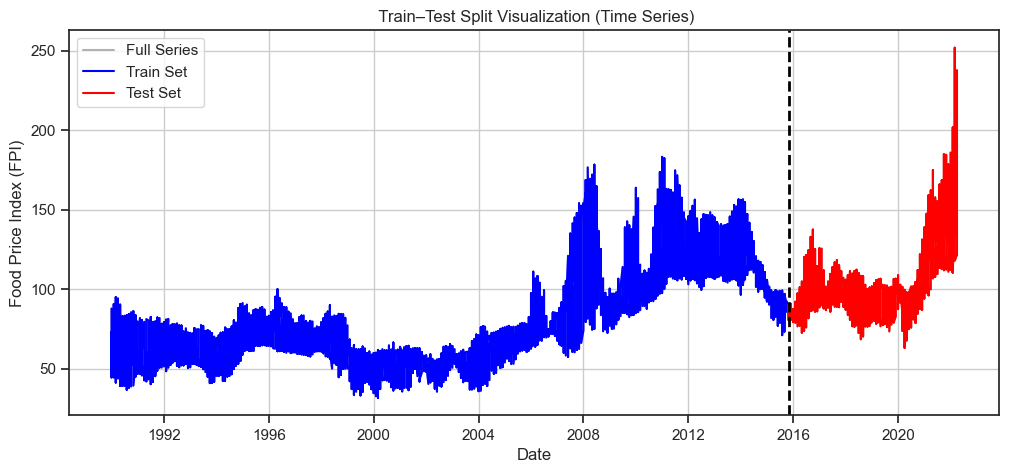

In [ ]:
plt.figure(figsize=(12,5))

# Plot the full series first
plt.plot(merged.index, merged['FPI'], label='Full Series', color='gray', alpha=0.6)

# Split the dataframe directly by position 
train_df = merged.iloc[:split_point]
test_df  = merged.iloc[split_point:]

plt.plot(train_df.index, train_df['FPI'], label='Train Set', color='blue')
plt.plot(test_df.index, test_df['FPI'], label='Test Set', color='red')

# Add split marker
plt.axvline(x=test_df.index.min(), color='black', linestyle='--', lw=2)

plt.title(" Train–Test Split Visualization (Time Series)")
plt.xlabel("Date")
plt.ylabel("Food Price Index (FPI)")
plt.legend()
plt.grid(True)
plt.show()


The FPI shows a clear upward trend over the entire period, with significant peaks in price volatility, particularly around 2008 and 2011/2012, and a sharp increase in the Test Set

In [ ]:
#  Train-test split (80% train, 20% test) — chronological for time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [ ]:
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (318460, 24)
Test shape : (79616, 24)


In [ ]:
# Use StandardScaler for regression
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#  Train ML Models

from sklearn.linear_model import LinearRegression, Ridge

# Dictionary to store trained models
trained_models = {}

#  Linear Regression 
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
trained_models['Linear Regression'] = lr_model

#  Ridge Regression 
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
trained_models['Ridge Regression'] = ridge_model

#  Random Forest 
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
trained_models['Random Forest'] = rf_model

#  Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)
trained_models['Gradient Boosting'] = gb_model

In [ ]:
#  Evaluate Models

results = {}

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Testing metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        "Train RMSE": train_rmse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }

# Convert results into a DataFrame
results_df = pd.DataFrame(results).T
display(results_df)


Evaluating Linear Regression...

Evaluating Ridge Regression...

Evaluating Random Forest...

Evaluating Gradient Boosting...


,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
Linear Regression,2.357631,0.538407,0.993529,2.266579,0.523799,0.989259
Ridge Regression,2.357637,0.538125,0.993529,2.266637,0.524534,0.989258
Random Forest,1.502127,0.433408,0.997373,4.738995,0.938488,0.953046
Gradient Boosting,1.965281,0.525375,0.995504,4.816587,0.939920,0.951496


Feature Importance

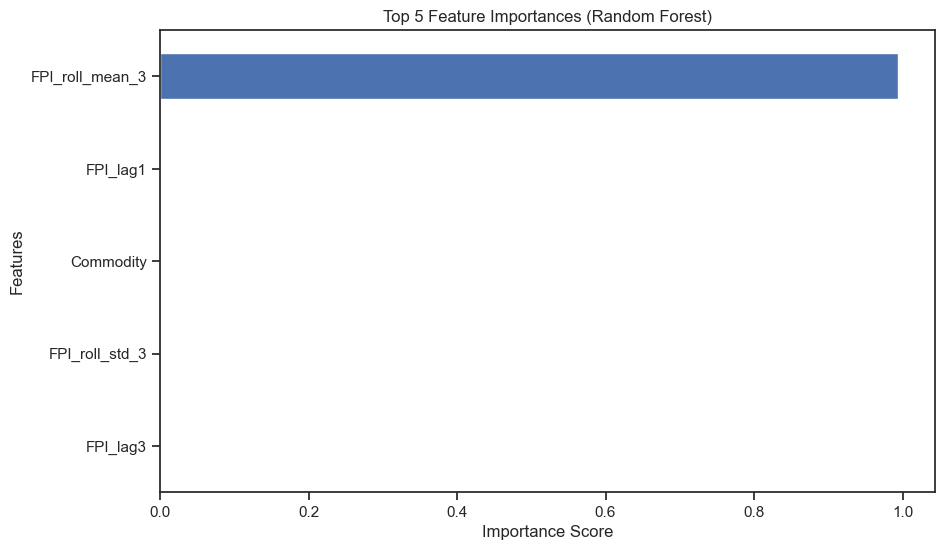

In [ ]:
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(5).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 5 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


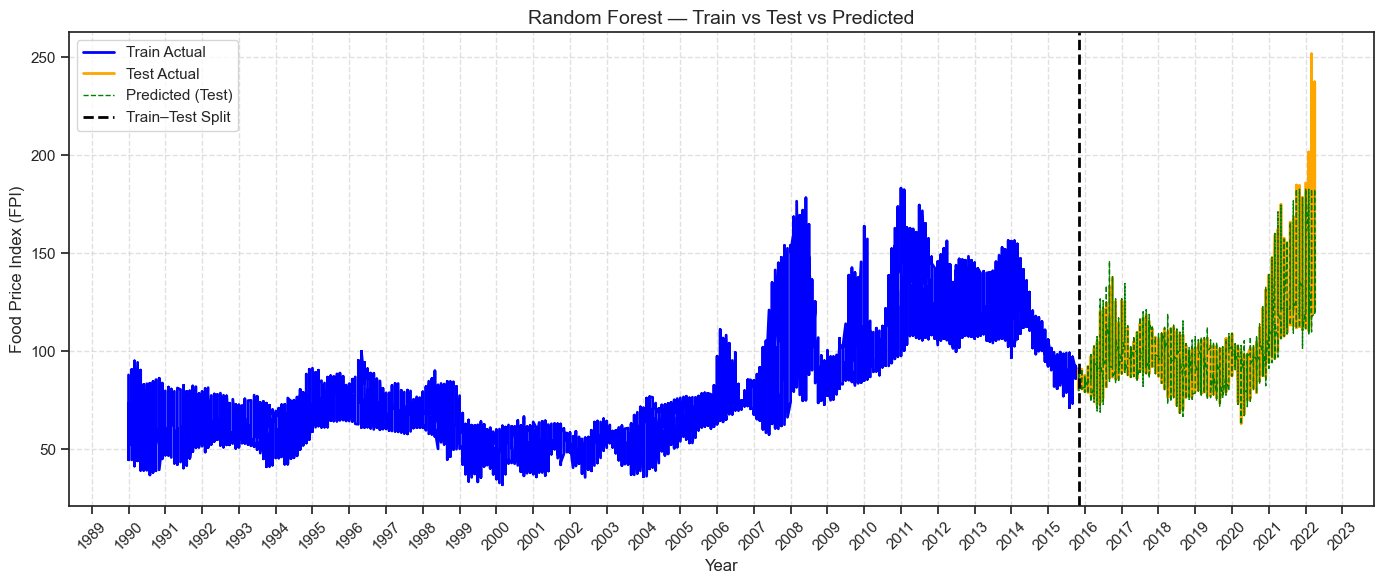

In [ ]:

#  Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

#  Dates (assumes X has a datetime index )
dates_train = X_train.index
dates_test = X_test.index

#  Combine actual and predicted into one DataFrame
results_rf = pd.DataFrame({
    'Date': list(dates_train) + list(dates_test),
    'Actual FPI': np.concatenate([y_train, y_test])
})
results_rf['Type'] = ['Train'] * len(dates_train) + ['Test'] * len(dates_test)
results_rf['Predicted FPI'] = [None] * len(dates_train) + list(y_test_pred_rf.flatten())

#  Plot
plt.figure(figsize=(14, 6))
plt.plot(results_rf.loc[results_rf['Type'] == 'Train', 'Date'],
         results_rf.loc[results_rf['Type'] == 'Train', 'Actual FPI'],
         label='Train Actual', color='blue', linewidth=2)

plt.plot(results_rf.loc[results_rf['Type'] == 'Test', 'Date'],
         results_rf.loc[results_rf['Type'] == 'Test', 'Actual FPI'],
         label='Test Actual', color='orange', linewidth=2)

plt.plot(results_rf.loc[results_rf['Type'] == 'Test', 'Date'],
         results_rf.loc[results_rf['Type'] == 'Test', 'Predicted FPI'],
         label='Predicted (Test)', color='green', linestyle='--', linewidth=1.0)

# Vertical split line
plt.axvline(x=dates_test[0], color='black', linestyle='--', lw=2, label='Train–Test Split')

#  Titles and formatting
plt.title("Random Forest — Train vs Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

#  Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


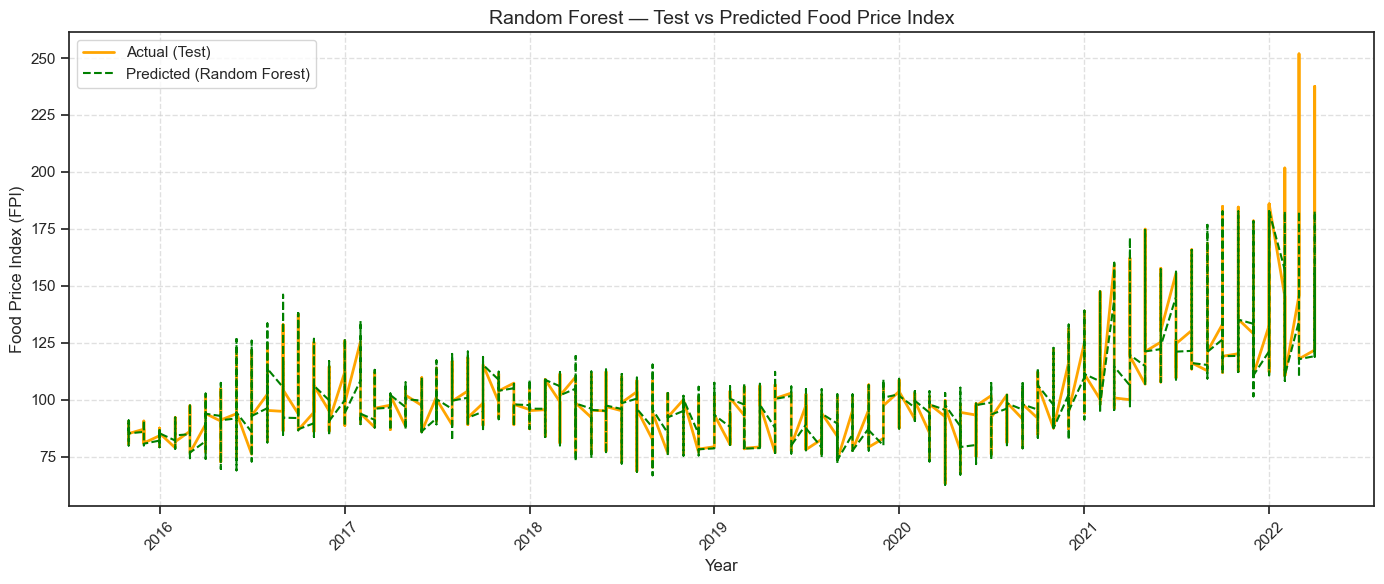

In [ ]:
#  Predictions
y_test_pred_rf = rf_model.predict(X_test_scaled)

#  Dates (assumes X has a datetime index or 'Date' column)
dates_test = X_test.index

#  Combine actual and predicted for the test set only
results_rf_test = pd.DataFrame({
    'Date': dates_test,
    'Actual FPI': y_test,
    'Predicted FPI': y_test_pred_rf
})

#  Plot Test vs Predicted
plt.figure(figsize=(14, 6))

plt.plot(results_rf_test['Date'], results_rf_test['Actual FPI'],
         label='Actual (Test)', color='orange', linewidth=2)

plt.plot(results_rf_test['Date'], results_rf_test['Predicted FPI'],
         label='Predicted (Random Forest)', color='green', linestyle='--', linewidth=1.5)

#  Titles and formatting
plt.title("Random Forest — Test vs Predicted Food Price Index", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

#  Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series Models

In [ ]:
# Use same X_train_scaled, X_test_scaled, y_train, y_test from ML
X_train_exog = X_train_scaled
X_test_exog = X_test_scaled
y_train_exog = y_train
y_test_exog = y_test

In [ ]:
print("Features & target shapes:")
print("X_train:", X_train_exog.shape, "X_test:", X_test_exog.shape)
print("y_train:", y_train_exog.shape, "y_test:", y_test_exog.shape)

Features & target shapes:
X_train: (318460, 24) X_test: (79616, 24)
y_train: (318460,) y_test: (79616,)


# ARIMAX Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMAX
arimax_model = ARIMA(
    endog=y_train_exog,
    exog=X_train_exog,
    order=(1,1,0)
)
arimax_fit = arimax_model.fit()

c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

In [ ]:
# Predictions
y_train_pred_arimax = arimax_fit.predict(start=0, end=len(y_train_exog)-1, exog=X_train_exog)
y_test_pred_arimax = arimax_fit.predict(start=len(y_train_exog), end=len(y_train_exog)+len(y_test_exog)-1, exog=X_test_exog)

c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Metrics
train_rmse_arimax = np.sqrt(mean_squared_error(y_train_exog, y_train_pred_arimax))
train_mae_arimax = mean_absolute_error(y_train_exog, y_train_pred_arimax)
train_r2_arimax = r2_score(y_train_exog, y_train_pred_arimax)

test_rmse_arimax = np.sqrt(mean_squared_error(y_test_exog, y_test_pred_arimax))
test_mae_arimax = mean_absolute_error(y_test_exog, y_test_pred_arimax)
test_r2_arimax = r2_score(y_test_exog, y_test_pred_arimax)

# SARIMAX (Seasonal)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    endog=y_train_exog,
    exog=X_train_exog,
    order=(1,1,0),          # non-seasonal from ARIMA rationale
    seasonal_order=(1,1,1,12), # seasonal: P=1, D=1, Q=1, s=12
    enforce_stationarity=False,
    enforce_invertibility=False,
    method='lbfgs'
)
sarimax_fit = sarimax_model.fit(disp=False)

c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

In [ ]:
# Predictions
y_train_pred_sarimax = sarimax_fit.predict(start=0, end=len(y_train_exog)-1, exog=X_train_exog)
y_test_pred_sarimax = sarimax_fit.predict(start=len(y_train_exog), end=len(y_train_exog)+len(y_test_exog)-1, exog=X_test_exog)

c:\Users\JOY\Desktop\FOOD_PRICE_MONITOR\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Metrics
train_rmse_sarimax = np.sqrt(mean_squared_error(y_train_exog, y_train_pred_sarimax))
train_mae_sarimax = mean_absolute_error(y_train_exog, y_train_pred_sarimax)
train_r2_sarimax = r2_score(y_train_exog, y_train_pred_sarimax)

test_rmse_sarimax = np.sqrt(mean_squared_error(y_test_exog, y_test_pred_sarimax))
test_mae_sarimax = mean_absolute_error(y_test_exog, y_test_pred_sarimax)
test_r2_sarimax = r2_score(y_test_exog, y_test_pred_sarimax)

In [ ]:
ts_results = {
    "ARIMAX": {
        "Train RMSE": train_rmse_arimax,
        "Train MAE": train_mae_arimax,
        "Train R2": train_r2_arimax,
        "Test RMSE": test_rmse_arimax,
        "Test MAE": test_mae_arimax,
        "Test R2": test_r2_arimax
    },
    "SARIMAX": {
        "Train RMSE": train_rmse_sarimax,
        "Train MAE": train_mae_sarimax,
        "Train R2": train_r2_sarimax,
        "Test RMSE": test_rmse_sarimax,
        "Test MAE": test_mae_sarimax,
        "Test R2": test_r2_sarimax
    }
}

ts_results_df = pd.DataFrame(ts_results).T
display(ts_results_df)


,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
ARIMAX,0.336029,0.043481,0.999870,0.309954,0.026108,0.99989
SARIMAX,0.352321,0.044839,0.999857,0.309569,0.026529,0.99989


# LSTM Model

In [ ]:

HORIZON = 1        # Single-step forecast (only 1 month ahead)
SEQ_LEN = 12       # Lookback window (12 past months)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50
LSTM_UNITS = 64
DROPOUT = 0.2
L2_ALPHA = 1e-4    # L2 regularization



In [ ]:

merged = merged.sort_index()   # ensures chronological order
merged = merged.dropna()       # drop rows with NaNs 
print("Index name:", merged.index.name)
print("Columns:", merged.columns.tolist()[:10], "...")
print("Shape:", merged.shape)


Index name: Date
Columns: ['Commodity', 'FPI', 'Country', 'Food_CPI', 'CPI', 'FPI_lag1', 'Food_CPI_lag1', 'FPI_lag3', 'Food_CPI_lag3', 'FPI_lag6'] ...
Shape: (398076, 25)


In [ ]:
X_all = merged.drop('FPI', axis=1).copy()
y_all = merged['FPI'].copy()

X_vals = X_all.values
y_vals = y_all.values.flatten()
dates = pd.to_datetime(X_all.index)
n_total = len(X_vals)

if n_total <= SEQ_LEN + HORIZON:
    raise ValueError("Not enough rows for SEQ_LEN + HORIZON.")


In [ ]:
X_seq, y_seq, sample_dates = [], [], []
for i in range(SEQ_LEN - 1, n_total - HORIZON):
    X_seq.append(X_vals[i - SEQ_LEN + 1:i + 1])      # (SEQ_LEN, n_features)
    y_seq.append(y_vals[i + HORIZON])                # only one step ahead
    sample_dates.append(dates[i])

X_seq = np.array(X_seq)   # (n_samples, SEQ_LEN, n_features)
y_seq = np.array(y_seq)   # (n_samples,)
print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)


X_seq shape: (398064, 12, 24) y_seq shape: (398064,)


In [ ]:
n_samples = X_seq.shape[0]
train_cut = int((1 - TEST_SIZE) * n_samples)

X_train, X_test = X_seq[:train_cut], X_seq[train_cut:]
y_train, y_test = y_seq[:train_cut], y_seq[train_cut:]
dates_train, dates_test = sample_dates[:train_cut], sample_dates[train_cut:]



In [ ]:
print(f"Training: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing : X_test  {X_test.shape}, y_test  {y_test.shape}")


Training: X_train (318451, 12, 24), y_train (318451,)
Testing : X_test  (79613, 12, 24), y_test  (79613,)


In [ ]:
# Feature scaling
n_features = X_train.shape[2]
feat_scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, n_features)
X_test_flat  = X_test.reshape(-1, n_features)

X_train_scaled = feat_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled  = feat_scaler.transform(X_test_flat).reshape(X_test.shape)

# Target scaling
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))


In [ ]:
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(SEQ_LEN, n_features),
         kernel_regularizer=l2(L2_ALPHA), recurrent_regularizer=l2(L2_ALPHA)),
    BatchNormalization(),
    Dropout(DROPOUT),
    Dense(64, activation='relu', kernel_regularizer=l2(L2_ALPHA)),
    Dense(1, activation='linear')   # single output neuron
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 27,137 (106.00 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlrop],
    verbose=1
)



Epoch 1/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - loss: 0.0123 - mae: 0.0453 - val_loss: 0.0026 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - loss: 0.0020 - mae: 0.0231 - val_loss: 0.0016 - val_mae: 0.0188 - learning_rate: 0.0010
Epoch 3/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - loss: 0.0017 - mae: 0.0220 - val_loss: 0.0018 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 4/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - loss: 0.0017 - mae: 0.0216 - val_loss: 0.0013 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 5/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - loss: 0.0016 - mae: 0.0215 - val_loss: 0.0015 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 6/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - loss: 0.0016 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0157 - learning_rate: 0.0010
Epoch 7/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 0.0016 - mae: 0.0214 - val_loss: 0.0013 - val_mae: 0.0151 - learnin

In [ ]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"LSTM Single-Step — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


2488/2488 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
LSTM Single-Step — RMSE: 4.0517, MAE: 1.3631, R²: 0.9657


In [ ]:
#  Evaluate on Training Set 
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_train_true = y_scaler.inverse_transform(y_train_scaled)

rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train  = mean_absolute_error(y_train_true, y_train_pred)
r2_train   = r2_score(y_train_true, y_train_pred)

print(f"LSTM Single-Step Train — RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")

#  Evaluate on Test Set 
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_true = y_scaler.inverse_transform(y_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test  = mean_absolute_error(y_test_true, y_test_pred)
r2_test   = r2_score(y_test_true, y_test_pred)

print(f"LSTM Single-Step Test — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

9952/9952 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
LSTM Single-Step Train — RMSE: 4.1532, MAE: 1.4998, R²: 0.9799
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
LSTM Single-Step Test — RMSE: 4.0517, MAE: 1.3631, R²: 0.9657


In [ ]:
#  Create DataFrame 
eval_df = pd.DataFrame({
    "LSTM": ["Train", "Test"],
    "RMSE": [rmse_train, rmse_test],
    "MAE": [mae_train, mae_test],
    "R2": [r2_train, r2_test]
})

eval_df = eval_df.set_index("LSTM")
eval_df

,RMSE,MAE,R2
LSTM,,,
Train,4.153198,1.499818,0.979921
Test,4.051670,1.363099,0.965679


Training & Validation Loss Curves

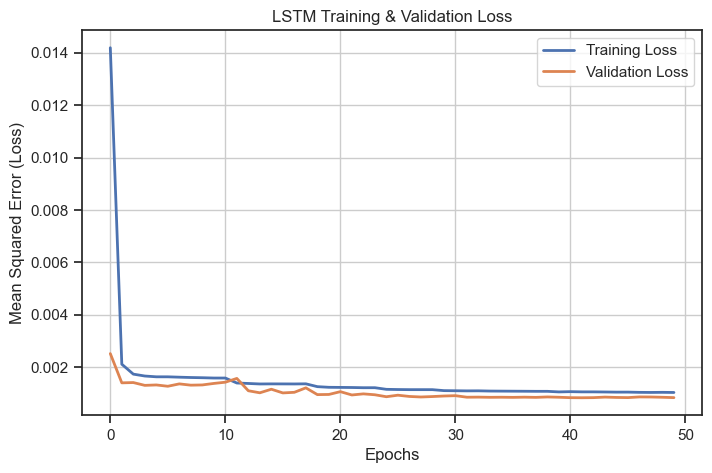

In [ ]:
#  Plot Training & Validation Loss Curves 
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()
plt.grid(True)
plt.show()


Both lines drop very quickly at the start (around 0-5 epochs) and then flatten out at a very low error value (around 0.002). This indicates the model learned the pattern of the data quickly and effectively and is not overfitting

Actual vs Predicted — Train Test Set

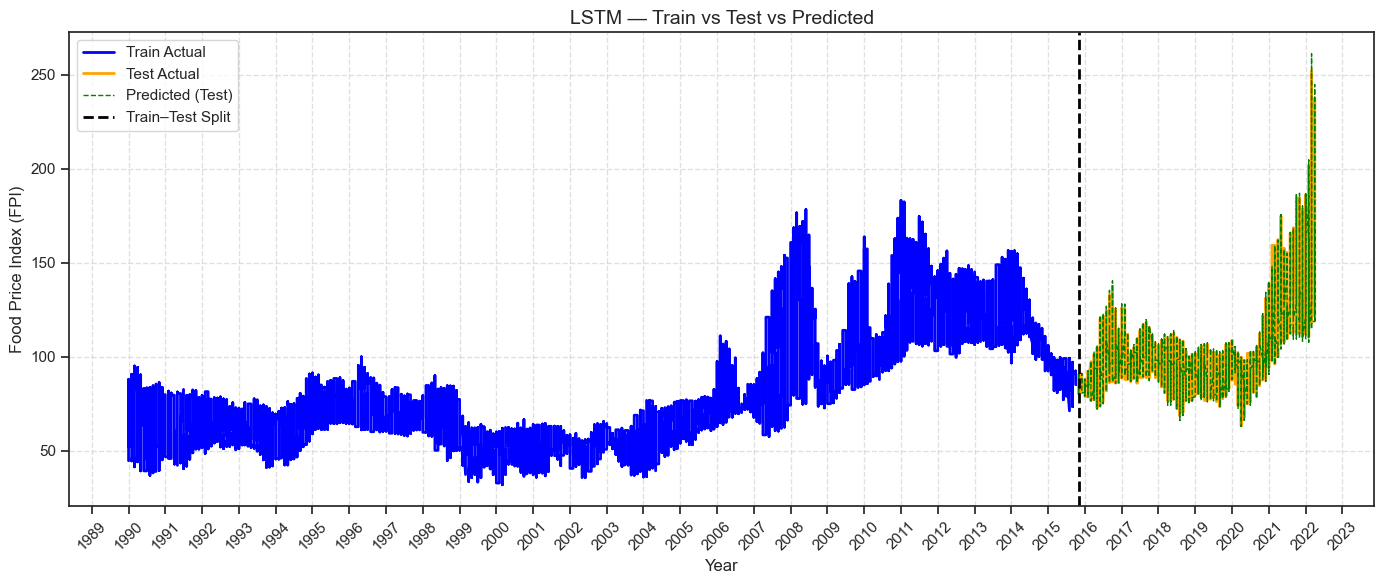

In [ ]:


# Combine actual and predicted data into one frame
results_lstm = pd.DataFrame({
    'Date': list(dates_train) + list(dates_test),
    'Actual FPI': np.concatenate([y_train, y_test])
})

# Add columns for train/test segmentation
results_lstm['Type'] = ['Train'] * len(dates_train) + ['Test'] * len(dates_test)
results_lstm['Predicted FPI'] = [None] * len(dates_train) + list(y_test_pred.flatten())

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_lstm.loc[results_lstm['Type']=='Train', 'Date'],
         results_lstm.loc[results_lstm['Type']=='Train', 'Actual FPI'],
         label='Train Actual', color='blue', linewidth=2)

plt.plot(results_lstm.loc[results_lstm['Type']=='Test', 'Date'],
         results_lstm.loc[results_lstm['Type']=='Test', 'Actual FPI'],
         label='Test Actual', color='orange', linewidth=2)

plt.plot(results_lstm.loc[results_lstm['Type']=='Test', 'Date'],
         results_lstm.loc[results_lstm['Type']=='Test', 'Predicted FPI'],
         label='Predicted (Test)', color='green', linestyle='--', linewidth=1.0)

# Vertical split line
plt.axvline(x=dates_test[0], color='black', linestyle='--', lw=2, label='Train–Test Split')

# Titles and formatting
plt.title("LSTM — Train vs Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The Predicted (Test) line (dashed green) appears to closely follow the Test Actual line in the period after the dashed vertical line (around 2016). This suggests that the LSTM model is good at forecasting the Food Price Index, as its predictions match the real-world outcome reasonably well.

Test vs Predicted


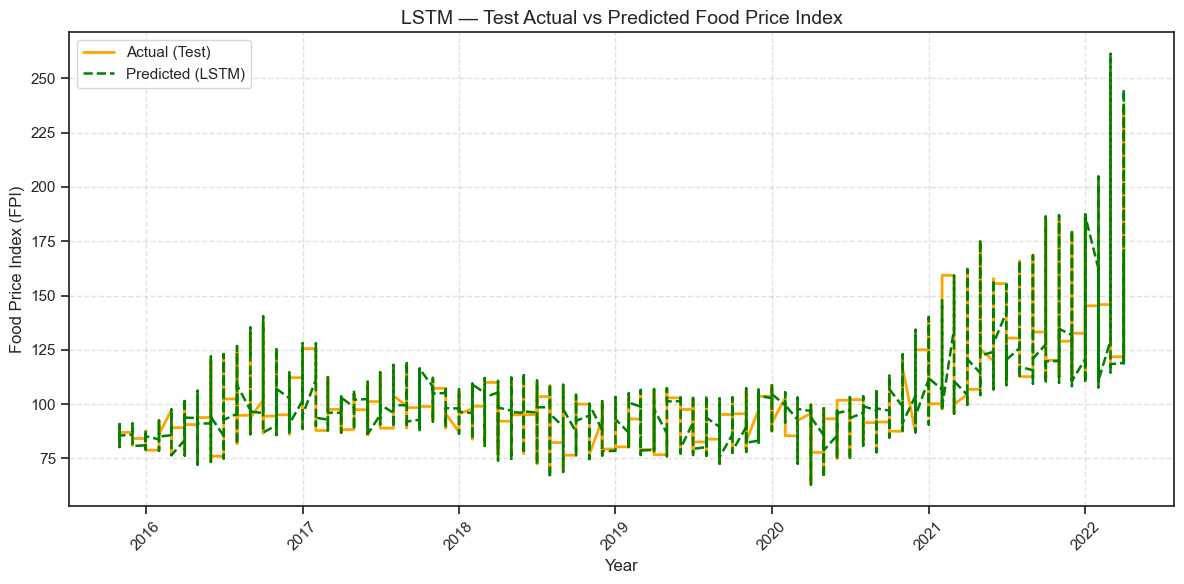

In [ ]:
# Combine test actual and predicted only
results_test = pd.DataFrame({
    'Date': dates_test,
    'Actual FPI': y_test.flatten(),
    'Predicted FPI': y_test_pred.flatten()
})

# Plot
plt.figure(figsize=(12, 6))

plt.plot(
    results_test['Date'],
    results_test['Actual FPI'],
    label='Actual (Test)', color='orange', linewidth=2
)

plt.plot(
    results_test['Date'],
    results_test['Predicted FPI'],
    label='Predicted (LSTM)', color='green', linestyle='--', linewidth=1.8
)

# Titles and formatting
plt.title("LSTM — Test Actual vs Predicted Food Price Index", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Format x-axis as years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Error Analysis

In [ ]:
#  Error Analysis Table for LSTM
error_analysis = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "RMSE": [rmse_train, rmse_test],
    "MAE": [mae_train, mae_test],
    "R²": [r2_train, r2_test],
    "Mean Error": [
        np.mean(y_train_true.flatten() - y_train_pred.flatten()),
        np.mean(y_test_true.flatten() - y_test_pred.flatten())
    ],
    "Std of Error": [
        np.std(y_train_true.flatten() - y_train_pred.flatten()),
        np.std(y_test_true.flatten() - y_test_pred.flatten())
    ]
})

# Display
error_analysis = error_analysis.set_index("Dataset")
display(error_analysis.style.background_gradient(cmap="YlOrBr").format(precision=4))


,RMSE,MAE,R²,Mean Error,Std of Error
Dataset,,,,,
Train,4.1532,1.4998,0.9799,-0.2580,4.1452
Test,4.0517,1.3631,0.9657,0.1441,4.0491


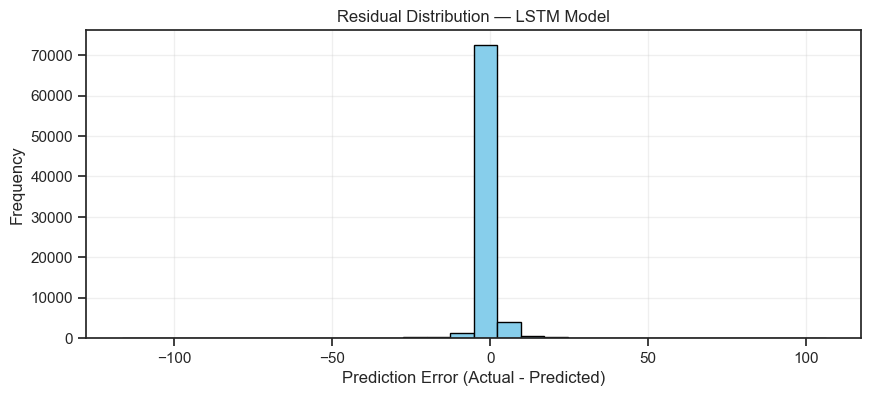

In [ ]:
# Compute residuals 
residuals = y_test_true.flatten() - y_test_pred.flatten()

#  Plot residual distribution 
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residual Distribution — LSTM Model")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

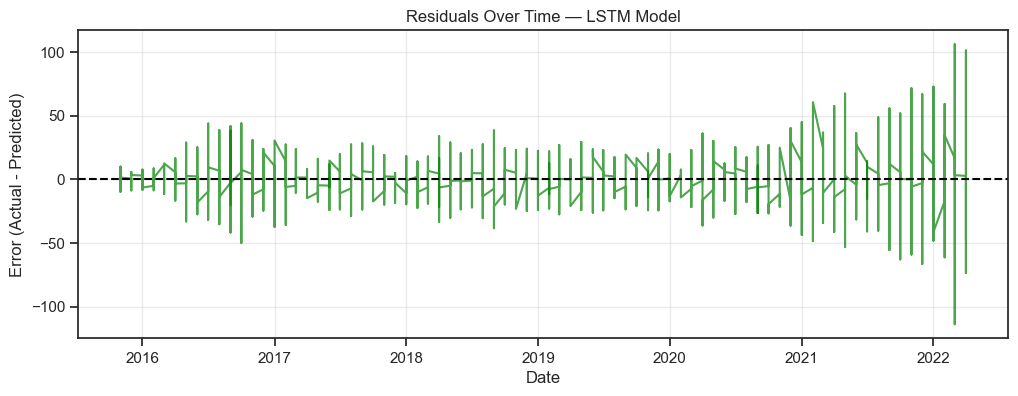

In [ ]:
#  Residual over time 
plt.figure(figsize=(12, 4))
plt.plot(dates_test, residuals, color='green', alpha=0.7)
plt.title("Residuals Over Time — LSTM Model")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.grid(alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [ ]:
# Save 1-month ahead predictions
results_1m = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test_true.flatten(),
    "Predicted": y_test_pred.flatten()
})

results_1m.to_csv("lstm_1month_predictions.csv", index=False)
print(" Saved 1-month ahead predictions to 'lstm_1month_predictions.csv'")
print(results_1m.shape)


 Saved 1-month ahead predictions to 'lstm_1month_predictions.csv'
(79613, 3)


# Tuning

In [ ]:
# Smaller Search Space

LSTM_UNITS_OPTIONS = [64, 128]     
DROPOUT_OPTIONS = [0.2, 0.4]        
L2_ALPHA_OPTIONS = [1e-4]           
BATCH_SIZE_OPTIONS = [32, 64]       
EPOCHS = 30                         

best_score = float('inf')
best_params = {}
n_features = X_train.shape[2]

In [ ]:
# 2Grid Search Loop

for units in LSTM_UNITS_OPTIONS:
    for dropout in DROPOUT_OPTIONS:
        for l2_alpha in L2_ALPHA_OPTIONS:
            for batch in BATCH_SIZE_OPTIONS:
                print(f" Testing: units={units}, dropout={dropout}, l2={l2_alpha}, batch={batch}")

                tf.keras.backend.clear_session()

                model = Sequential([
                    LSTM(units, input_shape=(SEQ_LEN, n_features),
                         kernel_regularizer=l2(l2_alpha),
                         recurrent_regularizer=l2(l2_alpha)),
                    BatchNormalization(),
                    Dropout(dropout),
                    Dense(64, activation='relu', kernel_regularizer=l2(l2_alpha)),
                    Dense(1, activation='linear')
                ])

                model.compile(optimizer='adam', loss='mse', metrics=['mae'])

                es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

                history = model.fit(
                    X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=EPOCHS,
                    batch_size=batch,
                    callbacks=[es],
                    verbose=0
                )

                val_loss = min(history.history['val_loss'])
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {'units': units, 'dropout': dropout, 'l2': l2_alpha, 'batch': batch}

print(" Best Parameters Found:", best_params)

 Testing: units=64, dropout=0.2, l2=0.0001, batch=32
 Testing: units=64, dropout=0.2, l2=0.0001, batch=64
 Testing: units=64, dropout=0.4, l2=0.0001, batch=32
 Testing: units=64, dropout=0.4, l2=0.0001, batch=64
 Testing: units=128, dropout=0.2, l2=0.0001, batch=32
 Testing: units=128, dropout=0.2, l2=0.0001, batch=64
 Testing: units=128, dropout=0.4, l2=0.0001, batch=32
 Testing: units=128, dropout=0.4, l2=0.0001, batch=64
 Best Parameters Found: {'units': 64, 'dropout': 0.2, 'l2': 0.0001, 'batch': 64}


### Retrain with Best Params

In [ ]:
#  Retrain with Best Params

tf.keras.backend.clear_session()

model = Sequential([
    LSTM(best_params['units'], input_shape=(SEQ_LEN, n_features),
         kernel_regularizer=l2(best_params['l2']),
         recurrent_regularizer=l2(best_params['l2'])),
    BatchNormalization(),
    Dropout(best_params['dropout']),
    Dense(64, activation='relu', kernel_regularizer=l2(best_params['l2'])),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=50,
    batch_size=best_params['batch'],
    callbacks=[es],
    verbose=1
)

Epoch 1/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - loss: 0.0191 - mae: 0.0559 - val_loss: 0.0053 - val_mae: 0.0255
Epoch 2/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0035 - mae: 0.0269 - val_loss: 0.0017 - val_mae: 0.0158
Epoch 3/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0017 - mae: 0.0211 - val_loss: 0.0017 - val_mae: 0.0231
Epoch 4/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0016 - mae: 0.0200 - val_loss: 0.0014 - val_mae: 0.0156
Epoch 5/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0015 - mae: 0.0197 - val_loss: 0.0017 - val_mae: 0.0252
Epoch 6/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0015 - mae: 0.0195 - val_loss: 0.0013 - val_mae: 0.0185
Epoch 7/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0014 - mae: 0.0194 - val_loss: 0.0012 - val_mae: 0.0178
Epoch 8/50
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0014 - mae: 0.0192 - val_loss: 0.0016 - val_mae: 0.0185
Epoch 9/50
4976/4976 ━━━━━━━━━━━

###  Evaluate Tuned Model

In [ ]:
#  Evaluate Tuned Model

y_train_pred = y_scaler.inverse_transform(model.predict(X_train_scaled))
y_test_pred = y_scaler.inverse_transform(model.predict(X_test_scaled))

y_train_true = y_scaler.inverse_transform(y_train_scaled)
y_test_true = y_scaler.inverse_transform(y_test_scaled)

rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train  = mean_absolute_error(y_train_true, y_train_pred)
r2_train   = r2_score(y_train_true, y_train_pred)

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test  = mean_absolute_error(y_test_true, y_test_pred)
r2_test   = r2_score(y_test_true, y_test_pred)

9952/9952 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
print(" Tuned LSTM Performance:")
print(f"Train — RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Test  — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

 Tuned LSTM Performance:
Train — RMSE: 5.2872, MAE: 3.3331, R²: 0.9675
Test  — RMSE: 4.4328, MAE: 2.0113, R²: 0.9589


In [ ]:
print(" Tuned LSTM Performance:")
print(f"Train — RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Test  — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

 Tuned LSTM Performance:
Train — RMSE: 4.8759, MAE: 2.6965, R²: 0.9723
Test  — RMSE: 4.5529, MAE: 2.1186, R²: 0.9567


### LSTM Model Comparison (Before vs After Tuning)

In [ ]:

# Baseline (before tuning) — fill with  earlier results
baseline_results = {
    'Train RMSE': 4.209913,
    'Train MAE': 1.715235,
    'Train R2': 0.979368,
    'Test RMSE': 4.077039,
    'Test MAE': 1.398784,
    'Test R2': 0.965248
}

# Tuned (new) results
tuned_results = {
    'Train RMSE': rmse_train,
    'Train MAE': mae_train,
    'Train R2': r2_train,
    'Test RMSE': rmse_test,
    'Test MAE': mae_test,
    'Test R2': r2_test
}

# Create a comparison DataFrame
import pandas as pd

comparison_df = pd.DataFrame([baseline_results, tuned_results],
                             index=['Before Tuning', 'After Tuning'])

print("LSTM Model Comparison (Before vs After Tuning):")
display(comparison_df.style.set_caption("LSTM Model Performance Before and After Tuning")
       .format("{:.4f}")
       .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px'),
                                                            ('font-weight', 'bold'),
                                                            ('color', '#333')]}]))


LSTM Model Comparison (Before vs After Tuning):


,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
Before Tuning,4.2099,1.7152,0.9794,4.0770,1.3988,0.9652
After Tuning,5.2872,3.3331,0.9675,4.4328,2.0113,0.9589


# LSTM PREDICTING NEXT 6 MONTHS 

In [ ]:

HORIZON = 6        # forecast next 6 months (change to 3 if needed)
SEQ_LEN = 12       # lookback window (12 past months)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50
LSTM_UNITS = 64
DROPOUT = 0.2
L2_ALPHA = 1e-4    # small L2 regularization



In [ ]:
# Just ensure it's time-sorted and clean

merged = merged.sort_index()   # ensures chronological order
merged = merged.dropna()       # drop rows with NaNs (recommended)

print("Index name:", merged.index.name)
print("Columns:", merged.columns.tolist()[:10], "...")
print("Shape:", merged.shape)


Index name: Date
Columns: ['Commodity', 'FPI', 'Country', 'Food_CPI', 'CPI', 'FPI_lag1', 'Food_CPI_lag1', 'FPI_lag3', 'Food_CPI_lag3', 'FPI_lag6'] ...
Shape: (398076, 25)


Features & target arrays

In [ ]:
X_all = merged.drop('FPI', axis=1).copy()
y_all = merged['FPI'].copy()

X_vals = X_all.values
y_vals = y_all.values.flatten()
dates = pd.to_datetime(X_all.index)
n_total = len(X_vals)

if n_total <= SEQ_LEN + HORIZON:
    raise ValueError("Not enough rows for SEQ_LEN + HORIZON.")


Create supervised sequences (sliding windows)

In [ ]:
X_seq, y_seq, sample_dates = [], [], []
for i in range(SEQ_LEN - 1, n_total - HORIZON):
    X_seq.append(X_vals[i - SEQ_LEN + 1:i + 1])        # (SEQ_LEN, n_features)
    y_seq.append(y_vals[i + 1:i + 1 + HORIZON])        # (HORIZON,)
    sample_dates.append(dates[i])

X_seq = np.array(X_seq)   # (n_samples, SEQ_LEN, n_features)
y_seq = np.array(y_seq)   # (n_samples, HORIZON)

print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)


X_seq shape: (398059, 12, 24) y_seq shape: (398059, 6)


In [ ]:
n_samples = X_seq.shape[0]
train_cut = int((1 - TEST_SIZE) * n_samples)

X_train, X_test = X_seq[:train_cut], X_seq[train_cut:]
y_train, y_test = y_seq[:train_cut], y_seq[train_cut:]
dates_train, dates_test = sample_dates[:train_cut], sample_dates[train_cut:]

print(f"Training: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing : X_test  {X_test.shape}, y_test  {y_test.shape}")
print(f"SEQ_LEN={SEQ_LEN}, HORIZON={HORIZON}, n_features={X_train.shape[2]}")


Training: X_train (318447, 12, 24), y_train (318447, 6)
Testing : X_test  (79612, 12, 24), y_test  (79612, 6)
SEQ_LEN=12, HORIZON=6, n_features=24


In [ ]:
# feature scaling (StandardScaler)
n_features = X_train.shape[2]
feat_scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat  = X_test.reshape(-1, n_features)
X_train_scaled = feat_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled  = feat_scaler.transform(X_test_flat).reshape(X_test.shape)

# target scaling (MinMaxScaler) - fit on training targets
y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)


Build the LSTM model

In [ ]:
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(SEQ_LEN, n_features),
         kernel_regularizer=l2(L2_ALPHA), recurrent_regularizer=l2(L2_ALPHA)),
    BatchNormalization(),
    Dropout(DROPOUT),
    Dense(64, activation='relu', kernel_regularizer=l2(L2_ALPHA)),
    Dense(HORIZON, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,590 (107.77 KB)

 Trainable params: 27,462 (107.27 KB)

 Non-trainable params: 128 (512.00 B)

LSTM captures temporal patterns.

L2 regularizers (kernel_regularizer, recurrent_regularizer) penalize large weights → helps generalize.

BatchNormalization stabilizes learning.

Dropout reduces overfitting.

Final Dense(HORIZON) produces the multi-step forecast.

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


EarlyStopping halts training when validation loss stops improving (prevents overfitting). ReduceLROnPlateau reduces the learning rate when progress stalls to refine learning.

# Train the model

In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlrop],
    verbose=1
)

Epoch 1/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.0117 - mae: 0.0474 - val_loss: 0.0022 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 2/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0022 - val_mae: 0.0200 - learning_rate: 0.0010
Epoch 3/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - loss: 0.0024 - mae: 0.0257 - val_loss: 0.0022 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 4/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 67s 7ms/step - loss: 0.0024 - mae: 0.0254 - val_loss: 0.0019 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 5/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - loss: 0.0023 - mae: 0.0251 - val_loss: 0.0018 - val_mae: 0.0171 - learning_rate: 0.0010
Epoch 6/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - loss: 0.0023 - mae: 0.0251 - val_loss: 0.0019 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 7/50
9952/9952 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - loss: 0.0023 - mae: 0.0248 - val_loss: 0.0025 - val_mae: 0.0224 - learnin

In [ ]:
#  Make predictions on Train and Test sets
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled  = model.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred  = y_scaler.inverse_transform(y_test_pred_scaled)

9952/9952 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
#  Compute and summarize error metrics for Train & Test sets ---

def multi_metrics(y_true, y_pred):
    metrics = {}
    for h in range(y_true.shape[1]):
        mse  = mean_squared_error(y_true[:, h], y_pred[:, h])
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_true[:, h], y_pred[:, h])
        r2   = r2_score(y_true[:, h], y_pred[:, h])
        metrics[f"H{h+1}"] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return metrics

In [ ]:
# Compute metrics
train_metrics = multi_metrics(y_train, y_train_pred)
test_metrics  = multi_metrics(y_test,  y_test_pred)

In [ ]:
# Create summary DataFrame
error_summary = pd.DataFrame({
    "Horizon": list(train_metrics.keys()),
    "Train_RMSE": [v['RMSE'] for v in train_metrics.values()],
    "Train_MAE":  [v['MAE']  for v in train_metrics.values()],
    "Train_R²":   [v['R2']   for v in train_metrics.values()],
    "Test_RMSE":  [v['RMSE'] for v in test_metrics.values()],
    "Test_MAE":   [v['MAE']  for v in test_metrics.values()],
    "Test_R²":    [v['R2']   for v in test_metrics.values()]
})

In [ ]:
# Add average row
error_summary.loc["Average"] = [
    "Mean Across All",
    error_summary["Train_RMSE"].mean(),
    error_summary["Train_MAE"].mean(),
    error_summary["Train_R²"].mean(),
    error_summary["Test_RMSE"].mean(),
    error_summary["Test_MAE"].mean(),
    error_summary["Test_R²"].mean()
]

# Display styled table
display(error_summary)

,Horizon,Train_RMSE,Train_MAE,Train_R²,Test_RMSE,Test_MAE,Test_R²
0,H1,4.116844,1.298739,0.980271,4.115198,1.533576,0.964578
1,H2,4.828787,1.540167,0.972857,4.771932,1.726664,0.952376
2,H3,5.437027,1.780622,0.965588,5.342930,1.937361,0.940304
3,H4,5.965083,2.031291,0.958579,5.860824,2.181735,0.928178
4,H5,6.429957,2.271120,0.951871,6.311028,2.418048,0.916730
5,H6,6.840999,2.504227,0.945521,6.720555,2.656512,0.905573
Average,Mean Across All,5.603116,1.904361,0.962448,5.520411,2.075649,0.934623


In [ ]:
#  Save clean 6-month multi-horizon predictions ---


print("dates_test:", len(dates_test))
print("y_test_true:", y_test_true.shape)
print("y_test_pred:", y_test_pred.shape)

results_6m = pd.DataFrame({"Date": dates_test})

for i in range(y_test_pred.shape[1]):  # 6 horizons
    results_6m[f"Actual_H{i+1}"] = y_test_true[:, i]
    results_6m[f"Predicted_H{i+1}"] = y_test_pred[:, i]

results_6m.to_csv("lstm_6month_predictions.csv", index=False)
print(" Saved 6-month ahead multi-horizon predictions to 'lstm_6month_predictions.csv'")
print(results_6m.shape)


dates_test: 79612
y_test_true: (79612, 6)
y_test_pred: (79612, 6)
 Saved 6-month ahead multi-horizon predictions to 'lstm_6month_predictions.csv'
(79612, 13)


In [ ]:
#  Actual vs Predicted (last horizon only)
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test[:, -1], label="Actual (6-Month Ahead)", color="orange", linewidth=2)
plt.plot(dates_test, y_pred[:, -1], label="Predicted (6-Month Ahead)", color="green", linestyle="--", linewidth=1.5)
plt.title("LSTM Multi-Step Forecast — Actual vs Predicted (6-Month Ahead)")
plt.xlabel("Date")
plt.ylabel("Food Price Index (FPI)")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

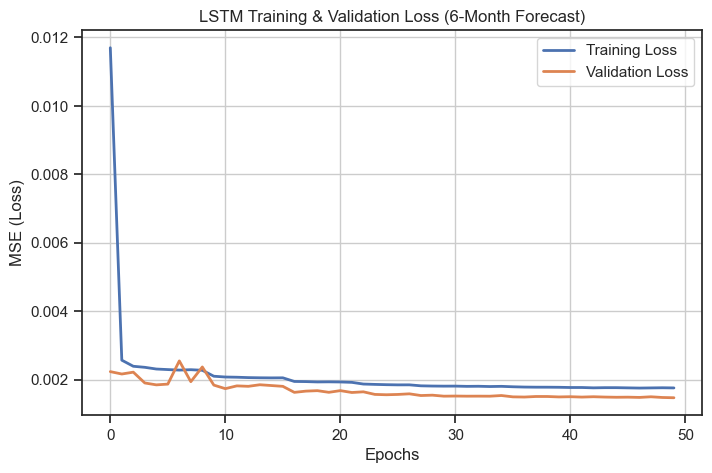

In [ ]:
#  Training & Validation Loss 
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("LSTM Training & Validation Loss (6-Month Forecast)")
plt.xlabel("Epochs")
plt.ylabel("MSE (Loss)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  Residual Analysis (last horizon only) 
residuals = y_test[:, -1] - y_pred[:, -1]

plt.figure(figsize=(12, 4))
plt.plot(dates_test, residuals, color='purple', alpha=0.7)
plt.title("Residuals Over Time — LSTM (6-Month Horizon)")
plt.xlabel("Date")
plt.ylabel("Error (Actual − Predicted)")
plt.axhline(0, color='black', linestyle='--')
plt.grid(alpha=0.4)
plt.show()

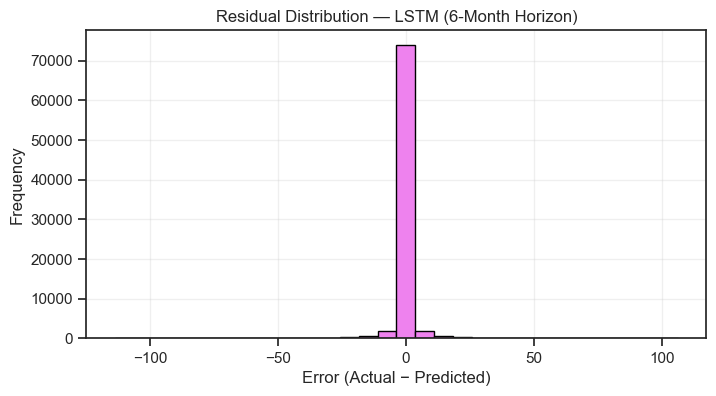

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='violet', edgecolor='black')
plt.title("Residual Distribution — LSTM (6-Month Horizon)")
plt.xlabel("Error (Actual − Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
merged.to_csv("merged.csv")
print(" merged.csv saved successfully")


 merged.csv saved successfully


In [ ]:
model.save("models/lstm_1month.h5")
# And for the 6-month model:
model.save("models/lstm_6month.h5")


In [ ]:
import joblib
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']